# Genomic surveillance analysis in Germany

In [172]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

## Download data
### Map
With zip codes for geo matching

In [173]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [174]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:01:15 --:--:--     0-:--  0:00:03 --:--:--     00 --:--:--  0:00:37 --:--:--     0    0      0      0 --:--:--  0:00:48 --:--:--     0    0      0      0 --:--:--  0:01:06 --:--:--     0
curl: (35) LibreSSL SSL_connect: SSL_ERROR_SYSCALL in connection to github.com:443 
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  

In [175]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [176]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [177]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [178]:
df.reason.value_counts()

N                             499643
X                             314220
A[B.1.1.7]                     35832
A[B.1.617.2]                   35813
Y                              31124
                               ...  
A[N501Y/E484K]                     0
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
A[E484E/N501N/P681R]               0
A[E484K/N501Y/P681R]               0
Name: reason, Length: 222, dtype: int64

In [179]:
import re

In [180]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10201-CVDP-924C0A0E-D051-41A5-AB2D-36631E92... 2022-06-19      N   
IMS-10201-CVDP-AE3EC821-0FE3-45EB-B77D-4D805F7C... 2022-06-19      N   
IMS-10201-CVDP-E8A2AD7E-961F-480F-A937-43185AE2... 2022-06-19      N   
IMS-10201-CVDP-4EF0C020-31C9-4BC5-AA93-6D9F202A... 2022-06-19      N   
IMS-10201-CVDP-94CEC51E-05E4-4060-AA99-16FAC0BC... 2022-06-19      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10201-CVDP-924C0A0E-D051-41A5-AB2D-36631E92...      2022-06-24      32429   
IMS-10201-CVDP-AE3EC821-0FE3-45EB-B77D-4D805F7C...      2022-06-24      32429   
IMS-10201-CVDP-E8A2AD7E-961F-480F-A937-43185AE2...      2022-06-24      32429   
IMS-10201-CVDP-4EF0C020-31C9-4BC5-AA93-6D9F202A...      2022-06-24      32429   
IMS-10201-CVDP-94CEC51E-05E4-4060-AA99-16FAC0BC...      2022-06-24      32429   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                       40225  B.1.1.297   
IMS-10294-CVDP-00325                                       40225    B.1.221   
IMS-10294-CVDP-00326                                       40225    B.1.160   
IMS-10294-CVDP-00327                                       40225    B.1.258   
IMS-10294-CVDP-00329                                       40225  B.1.1.521   
...                                                          ...        ...   
IMS-10201-CVDP-924C0A0E-D051-41A5-AB2D-36631E92...         32429       BA.5   
IMS-10201-CVDP-AE3EC821-0FE3-45EB-B77D-4D805F7C...         32429       BA.2   
IMS-10201-CVDP-E8A2AD7E-961F-480F-A937-43185AE2...         32429       BA.2   
IMS-10201-CVDP-4EF0C020-31C9-4BC5-AA93-6D9F202A...         32429       BA.5   
IMS-10201-CVDP-94CEC51E-05E4-4060-AA99-16FAC0BC...         32429       BA.5   

                                                   scorpio  \
IMS_ID                                                       
IMS-10294-CVDP-00001                                   NaN   
IMS-10294-CVDP-00325                                   NaN   
IMS-10294-CVDP-00326                                   NaN   
IMS-10294-CVDP-00327                                   NaN   
IMS-10294-CVDP-00329                                   NaN   
...                                                    ...   
IMS-10201-CVDP-924C0A0E-D051-41A5-AB2D-36631E92...     NaN   
IMS-10201-CVDP-AE3EC821-0FE3-45EB-B77D-4D805F7C...     NaN   
IMS-10201-CVDP-E8A2AD7E-961F-480F-A937-43185AE2...     NaN   
IMS-10201-CVDP-4EF0C020-31C9-4BC5-AA93-6D9F202A...     NaN   
IMS-10201-CVDP-94CEC51E-05E4-4060-AA99-16FAC0BC...     NaN   

                                                             bundesland  
IMS_ID                                                                   
IMS-10294-CVDP-00001                                Nordrhein-Westfalen  
IMS-10294

In [181]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5         10955
BA.2          5841
BA.2.9        1883
BA.4          1316
BA.2.12.1     1166
BA.2.36        394
BA.2.3         241
BA.2.18        167
BA.2.13         67
BA.2.23         62
BA.2.1          61
BA.2.38         45
BA.2.5          42
BA.2.40.1       40
BA.2.10         38
BA.2.37         37
BA.5.1          36
XM              36
BA.2.11         33
BA.2.8          23
BA.2.14         23
BA.2.41         22
BA.2.35         18
BA.2.12         18
BA.2.9.1        14
BA.1.1          11
XE               9
BA.2.6           8
BA.2.29          6
BA.2.31          5
BA.2.10.1        5
BA.2.3.2         5
BA.2.19          5
BA.2.23.1        5
XW               5
BA.2.28          4
BA.1.1.1         4
BA.2.22          4
BA.2.7           3
BA.2.30          3
BA.2.26          2
B.1.617.2        2
AY.43            2
BA.2.21          2
BA.1.18          2
BA.2.20          2
BA.2.39          2
XG               2
B.1              2
BA.2.2           1
BA.2.27          1
BA.2.25          1
BA.1.1.14   

In [310]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [311]:
ba = [x for x in l if x.startswith('BA') ]
ba

['BA.1',
 'BA.1.1',
 'BA.1.13',
 'BA.1.15',
 'BA.1.17',
 'BA.1.17.2',
 'BA.1.18',
 'BA.1.19',
 'BA.1.21',
 'BA.1.9',
 'BA.1.1.1',
 'BA.1.1.10',
 'BA.1.1.11',
 'BA.1.1.13',
 'BA.1.1.14',
 'BA.1.1.15',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.1.3',
 'BA.1.10',
 'BA.1.12',
 'BA.1.14',
 'BA.1.14.1',
 'BA.1.15.1',
 'BA.1.16',
 'BA.1.20',
 'BA.1.21.1',
 'BA.1.4',
 'BA.1.5',
 'BA.1.7',
 'BA.1.8',
 'BA.2',
 'BA.2.9',
 'BA.3',
 'BA.1.1.12',
 'BA.1.1.17',
 'BA.1.1.4',
 'BA.1.1.6',
 'BA.1.1.7',
 'BA.1.1.8',
 'BA.1.1.9',
 'BA.1.13.1',
 'BA.1.14.2',
 'BA.1.15.2',
 'BA.1.16.2',
 'BA.1.2',
 'BA.1.3',
 'BA.1.6',
 'BA.2.1',
 'BA.2.10',
 'BA.2.10.1',
 'BA.2.12',
 'BA.2.13',
 'BA.2.14',
 'BA.2.17',
 'BA.2.19',
 'BA.2.23',
 'BA.2.29',
 'BA.2.3',
 'BA.2.36',
 'BA.2.37',
 'BA.2.39',
 'BA.2.4',
 'BA.2.5',
 'BA.1.17.1',
 'BA.2.11',
 'BA.2.24',
 'BA.2.25',
 'BA.2.32',
 'BA.2.33',
 'BA.2.38',
 'BA.2.7',
 'BA.2.18',
 'BA.2.25.1',
 'BA.2.31',
 'BA.2.34',
 'BA.2.8',
 'BA.3.1',
 'BA.2.10.2',
 'BA.2.15',
 'BA

In [312]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       BA.1  BA.1.1  BA.1.13  BA.1.15  BA.1.17  \
bundesland        date                                                  
Baden-Württemberg 2021-11-01     0       0        0        0        0   
                  2021-11-02     0       0        0        0        0   
                  2021-11-03     0       0        0        0        0   
                  2021-11-04     0       0        0        0        0   
                  2021-11-05     0       0        0        0        0   
...                            ...     ...      ...      ...      ...   
Thüringen         2022-06-18     0       0        0        0        0   
                  2022-06-19     0       0        0        0        0   
                  2022-06-20     0       0        0        0        0   
                  2022-06-21     0       0        0        0        0   
                  2022-06-24     0       0        0        0        0   

lineage                       BA.1.17.2  BA.1.18  BA.1.19  BA.1.21  BA.1.9  \
bundesland        date                                                       
Baden-Württemberg 2021-11-01          0        0        0        0       0   
                  2021-11-02          0        0        0        0       0   
                  2021-11-03          0        0        0        0       0   
                  2021-11-04          0        0        0        0       0   
                  2021-11-05          0        0        0        0       0   
...                                 ...      ...      ...      ...     ...   
Thüringen         2022-06-18          0        0        0        0       0   
                  2022-06-19          0        0        0        0       0   
                  2022-06-20          0        0        0        0       0   
                  2022-06-21          0        0        0        0       0   
                  2022-06-24          0        0        0        0       0   

lineage                       ...  BA.2.41  BA.4  BA.2.20  BA.2.21  BA.5.1  \
bundesland        date        ...                                            
Baden-Württemberg 2021-11-01  ...        0     0        0        0       0   
                  2021-11-02  ...        0     0        0        0       0   
                  2021-11-03  ...        0     0        0        0       0   
                  2021-11-04  ...        0     0        0        0       0   
                  2021-11-05  ...        0     0        0        0       0   
...                           ...      ...   ...      ...      ...     ...   
Thüringen         2022-06-18  ...        0     0        0        0       0   
                  2022-06-19  ...        0     0        0        0       0   
                  2022-06-20  ...        0     0        0        0       0   
                  2022-06-21  ...        0     1        0        0       0   
                  2022-06-24  ...        0     0        0        0       0   

lineage                       BA.2.40.1  BA.2.28  Other  BA.2.40  B.1.617.2  
bundesland        date                                                       
Baden-Württemberg 2021-11-01          0        0      0        0        142  
                  2021-11-02          0        0      0        0        350  
                  2021-11-03          0        0      0        0        704  
                  2021-11-04          0        0      0        0       1044  
                  2021-11-05          0        0      0        0       1210  
...                                 ...      ...    ...      ...        ...  
Thüringen         2022-06-18          0        0      0        0          0  
                  2022-06-19          0        0      0        0          0  
                  2022-06-20          0        0      0        0          0  
                  2022-06-21          0        0      0        0          0  
                  2022-06-24          0        0      0        0          0  

[3744

In [313]:
genomes.sum(level=0)

lineage                 BA.1  BA.1.1  BA.1.13  BA.1.15  BA.1.17  BA.1.17.2  \
bundesland                                                                   
Baden-Württemberg       5035   23630       58     1006     1756       2439   
Bayern                  1432    7616       30      238      396        763   
Berlin                   204     832       27       28       80        126   
Brandenburg              357    1247       19       18       95        127   
Bremen                   100     818        5       90       34         28   
Hamburg                 1288    3989        9      154      272        319   
Hessen                   445    1713       10       42      128        171   
Mecklenburg-Vorpommern   250     853        4       42       61        120   
Niedersachsen            368    1334        4       87       96        156   
Nordrhein-Westfalen     7085   28222       68     1114     1363       2469   
Rheinland-Pfalz          183     727        2       25       36         49   
Saarland                 270    1717       19       49       49         73   
Sachsen                 2241    9322       34      387      637        973   
Sachsen-Anhalt           283    1270        3       76       79         73   
Schleswig-Holstein      1287    4362       18      352      278        329   
Thüringen                184    1056        6       33       38         91   

lineage                 BA.1.18  BA.1.19  BA.1.21  BA.1.9  ...  BA.2.41  BA.4  \
bundesland                                                 ...                  
Baden-Württemberg          2458      118      254       6  ...       26   334   
Bayern                      672       27       40      10  ...       14   244   
Berlin                      208        6        3       0  ...        5    40   
Brandenburg                 272        1        6       0  ...        1    38   
Bremen                       52        0        4       0  ...        2     7   
Hamburg                    1912       16       20       4  ...        3    42   
Hessen                      183       16       15       0  ...        0    15   
Mecklenburg-Vorpommern      243        1        2       0  ...        0    35   
Niedersachsen               197       10        6       1  ...        5    95   
Nordrhein-Westfalen        4639      104      127      19  ...       45   588   
Rheinland-Pfalz              69        6        8       0  ...        0    41   
Saarland                    450        1       16       0  ...        2     3   
Sachsen                    1265      150       95       3  ...        2    73   
Sachsen-Anhalt              259        9       14       1  ...        0     4   
Schleswig-Holstein         1112       10       21       0  ...        7   395   
Thüringen                    71        5       11       1  ...        2    10   

lineage                 BA.2.20  BA.2.21  BA.5.1  BA.2.40.1  BA.2.28  Other  \
bundesland                                                                    
Baden-Württemberg             1       11      15         13        1    142   
Bayern                        1        0       2          2        0    101   
Berlin                        0        0       0          2        0     28   
Brandenburg                   0        0       5          0        0     24   
Bremen                        0        0       0          0        0     12   
Hamburg                       2        0       0          1        0     98   
Hessen                        0        0       0          3        0      6   
Mecklenburg-Vorpommern        0        0      17          1        0     19   
Niedersachsen                 0        0       0          1        0     27   
Nordrhein-Westfalen           2        2      11         20        1    453   
Rheinland-Pfalz               0        1       0          0        0     13   
Saarland                      1        0       0          0        0     17   
Sachsen                       

In [315]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

In [316]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [317]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [318]:
lineages = genomes.columns.to_list()

In [319]:
G.sum((0,1))

array([ 21012,  88708,    316,   3741,   5398,   8306,  14062,    480,
          642,     45,   1002,  14950,    102,    824,    267,   1545,
          863,    251,    408,     44,     50,     82,    199,    970,
           28,   1581,    449,    775,    130,      4,     18,     29,
          212, 181385,  51087,     33,     50,     20,     39,      6,
           33,     19,      5,      3,      4,      5,     22,      6,
            2,     30,   1026,   2430,    735,    822,    336,    167,
           47,    736,    455,    133,   5152,   2851,    646,     51,
           24,   1529,      3,    225,     31,    153,     42,      2,
          176,    167,    435,     15,     70,     25,    169,     42,
            7,      4,     10,      4,     47,      6,     65,      3,
           84,     66,     34,  14265,      1,   2287,     23,     21,
           10,     15,     39,    114,   1963,      7,     16,     74,
           61,      4,   1226,      0, 119354])

In [320]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 6), match='BA.1.1'>

In [321]:
from genomicsurveillance.misc import ancestor_matrix, alias

In [322]:
[alias(x, anti_alias=True) for x in lineages if any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])]

['B.1.1.529.5', 'B.1.1.529.2.12.1', 'B.1.1.529.4', 'B.1.1.529.5.1']

In [323]:
merged_lineages, G, _ = gs.preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in ["BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.2.12.1"]], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=1000000)
merged_lineages

Dropped lineages []


['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.4',
 'B.1.1.529.5',
 'B.1.617.2',
 'Other']

In [324]:
baseline = 'B.1.617.2'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.4',
 'B.1.1.529.5',
 'Other',
 'B.1.617.2']

In [325]:
pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages).sum()

B.1.1.529             1077.0
B.1.1.529.1          58555.0
B.1.1.529.1.1       108184.0
B.1.1.529.2         251762.0
B.1.1.529.2.12.1      2287.0
B.1.1.529.4           1963.0
B.1.1.529.5          14339.0
Other                 1226.0
B.1.617.2           119354.0
dtype: float64

In [326]:
with pd.option_context('display.max_rows', None,):
    print(pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages).loc[:,"2022-02-20",:])

                        B.1.1.529  B.1.1.529.1  B.1.1.529.1.1  B.1.1.529.2  \
bundesland                                                                   
Baden-Württemberg             2.0        113.0          372.0        431.0   
Bayern                        0.0          6.0           29.0         38.0   
Berlin                        0.0          2.0            0.0          6.0   
Brandenburg                   0.0          0.0            4.0          7.0   
Bremen                        0.0          0.0            0.0          0.0   
Hamburg                       0.0          0.0            0.0          0.0   
Hessen                        0.0          3.0            8.0         14.0   
Mecklenburg-Vorpommern        0.0          0.0            0.0          0.0   
Niedersachsen                 0.0          0.0            0.0          2.0   
Nordrhein-Westfalen           0.0         50.0           99.0        144.0   
Rheinland-Pfalz               0.0          3.0            0.0   

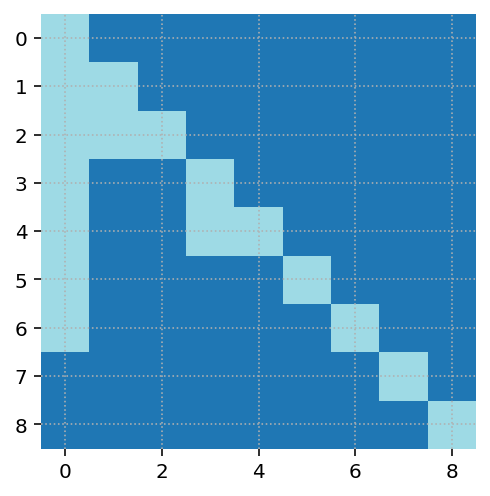

In [327]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

### Cases
Also from RKI

In [329]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [330]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A15-A34      W          2022-06-28  2022-06-28   
            A35-A59      W          2022-06-28  2022-06-28   
            A60-A79      W          2022-06-28  2022-06-28   
            A05-A14      W          2022-06-28  2022-06-28   
            A35-A59      W          2022-06-29  2022-06-29   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A15-A34      W          2022-06-28                     0   
            A35-A59      W          2022-06-28                     0   
            A60-A79      W          2022-06-28                     0   
            A05-A14      W          2022-06-28                     0   
            A35-A59      W          2022-06-29                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A15-A34      W          2022-06-28          1              -9   
            A35-A59      W          2022-06-28          1              -9   
            A60-A79      W          2022-06-28          1              -9   
            A05-A14      W          2022-06-28          1              -9   
            A35-A59      W          2022-06-29          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A15-A34      W          2022-06-28          -9           4   
            A35-A59      W          2022-06-28          -9          13   
            A60-A79      W          2022-06-28          -9           1   
            A05-A14      W          2022-06-28          -9           2   
            A35-A59      W          2022-06-29          -9           1   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [331]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

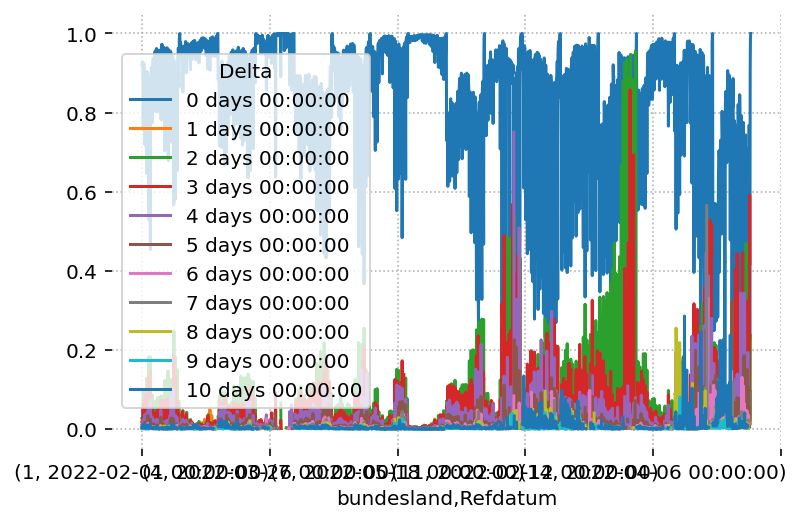

In [332]:
f.plot()

In [333]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [334]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [335]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.936676         0.954926         0.975426         0.988192   
Wed             0.938429         0.954116         0.976760         0.982895   
Thu             0.928180         0.949838         0.960663         0.966048   
Fri             0.921830         0.931581         0.941799         0.966427   
Sat             0.803762         0.819732         0.884964         0.947206   
Sun             0.713609         0.773547         0.877698         0.948278   
Mon             0.901209         0.925223         0.963317         0.980503   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.991309         0.992166         0.995817         0.997699   
Wed             0.984871         0.991993         0.996000         0.997782   
Thu             0.983144         0.992877         0.996591         0.997790   
Fri             0.984735         0.993008         0.995110         0.996997   
Sat             0.978766         0.987914         0.992463         0.993497   
Sun             0.972151         0.984596         0.984247         0.986935   
Mon             0.989970         0.992251         0.992833         0.995599   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.998259         0.998452               1.0  
Wed             0.998412         0.998818               1.0  
Thu             0.998382         0.998109               1.0  
Fri             0.997009         0.996375               1.0  
Sat             0.993406         0.996189               1.0  
Sun             0.992159         0.994519               1.0  
Mon             0.997152         0.998088               1.0

In [336]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [337]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [338]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999818  0.999665  0.999502  0.999013  0.997007   
Bayern                  0.995990  0.994567  0.990189  0.982533  0.957146   
Berlin                  0.992270  0.992682  0.987407  0.976406  0.903180   
Brandenburg             0.991373  0.991372  0.988306  0.980498  0.943577   
Bremen                  0.999078  0.999332  0.999279  0.998905  0.994241   
Hamburg                 0.997487  0.997626  0.997481  0.995341  0.990268   
Hessen                  0.998940  0.998501  0.996754  0.995864  0.985945   
Mecklenburg-Vorpommern  0.997875  0.997536  0.995457  0.993045  0.976104   
Niedersachsen           0.996218  0.995256  0.992919  0.987823  0.971730   
Nordrhein-Westfalen     0.996306  0.994911  0.991021  0.983777  0.963225   
Rheinland-Pfalz         0.999063  0.998218  0.994106  0.994860  0.975948   
Saarland                0.997788  0.996529  0.992177  0.991077  0.952794   
Sachsen                 0.998860  0.998723  0.997159  0.994912  0.987498   
Sachsen-Anhalt          0.979749  0.974919  0.984916  0.962444  0.843647   
Schleswig-Holstein      0.998259  0.997782  0.996591  0.993008  0.978766   
Thüringen               0.956384  0.963259  0.947411  0.915110  0.865010   

                               5         6         7         8  
Baden-Württemberg       0.991372  0.994441  0.995234  0.993482  
Bayern                  0.902919  0.881352  0.867744  0.844893  
Berlin                  0.761053  0.925488  0.917461  0.922131  
Brandenburg             0.838402  0.940478  0.953437  0.938792  
Bremen                  0.980238  0.986911  0.991094  0.992701  
Hamburg                 0.984069  0.983706  0.981795  0.978830  
Hessen                  0.953353  0.967641  0.962816  0.949058  
Mecklenburg-Vorpommern  0.944482  0.938647  0.865498  0.823972  
Niedersachsen           0.925239  0.941000  0.952078  0.940124  
Nordrhein-Westfalen     0.912041  0.914387  0.904371  0.873771  
Rheinland-Pfalz         0.933209  0.974351  0.978934  0.973919  
Saarland                0.887135  0.898813  0.947958  0.931306  
Sachsen                 0.965256  0.965797  0.960107  0.939282  
Sachsen-Anhalt          0.815061  0.844430  0.884800  0.907403  
Schleswig-Holstein      0.948278  0.963317  0.954926  0.938429  
Thüringen               0.727670  0.760389  0.766301  0.735642

In [339]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [340]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg           2149.0      2962.0      4411.0      4617.0   
Bayern                      6056.0      7162.0      9003.0      8867.0   
Berlin                      1326.0      1321.0      1443.0      1435.0   
Brandenburg                  855.0       952.0      1063.0      1074.0   
Bremen                        79.0        89.0        69.0        62.0   
Hamburg                      333.0       461.0       527.0       503.0   
Hessen                      1195.0      1597.0      1706.0      1574.0   
Mecklenburg-Vorpommern       418.0       428.0       405.0       317.0   
Niedersachsen               1189.0      1458.0      1674.0      1370.0   
Nordrhein-Westfalen         2573.0      3476.0      4367.0      4349.0   
Rheinland-Pfalz              651.0       996.0      1131.0      1060.0   
Saarland                     127.0       123.0       203.0       230.0   
Sachsen                     2847.0      3676.0      3486.0      3321.0   
Sachsen-Anhalt               646.0       855.0       721.0       738.0   
Schleswig-Holstein           337.0       389.0       366.0       354.0   
Thüringen                   1823.0      1431.0      1425.0      1504.0   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg           5070.0      4127.0      2278.0      4388.0   
Bayern                      9138.0      8739.0      7269.0      9388.0   
Berlin                      1452.0       970.0       758.0      2177.0   
Brandenburg                 1199.0      1141.0      1002.0      1296.0   
Bremen                        55.0        55.0        31.0        60.0   
Hamburg                      556.0       456.0       410.0       490.0   
Hessen                      1689.0      1312.0      1094.0      1469.0   
Mecklenburg-Vorpommern       543.0       504.0       314.0       528.0   
Niedersachsen               1403.0      1164.0       846.0      1622.0   
Nordrhein-Westfalen         4080.0      3707.0      2971.0      4454.0   
Rheinland-Pfalz             1030.0       798.0       770.0      1076.0   
Saarland                     185.0       214.0       155.0       209.0   
Sachsen                     3464.0      3212.0      2693.0      4475.0   
Sachsen-Anhalt               729.0       659.0       900.0       670.0   
Schleswig-Holstein           435.0       383.0       298.0       449.0   
Thüringen                   1433.0      1761.0      1195.0      1861.0   

Refdatum                2021-11-09  2021-11-10  ...  2022-06-20  2022-06-21  \
bundesland                                      ...                           
Baden-Württemberg           7123.0      7753.0  ...     10652.0     13187.0   
Bayern                     11229.0     12085.0  ...     15824.0     16849.0   
Berlin                      1916.0      2402.0  ...      3316.0      2994.0   
Brandenburg                 1468.0      1677.0  ...      1990.0      2344.0   
Bremen                       143.0        95.0  ...      1011.0      1095.0   
Hamburg                      538.0       568.0  ...      2670.0      3002.0   
Hessen                      1793.0      2021.0  ...      9977.0     10368.0   
Mecklenburg-Vorpommern       597.0       468.0  ...      1512.0      2419.0   
Niedersachsen               1753.0      2164.0  ...     12194.0     18124.0   
Nordrhein-Westfalen         5190.0      5317.0  ...     25443.0     28736.0   
Rheinland-Pfalz             1135.0      1326.0  ...      5905.0      6116.0   
Saarland                     273.0       301.0  ...      1860.0      1777.0   
Sachsen                     5757.0      5981.0  ...      2810.0      3572.0   
Sachsen-Anhalt              1018.0      1178.0  ...      1396.0      1741.0   
Schleswig-Holstein           487.0       542.0  ...      5441.0      5

In [341]:
cases_land.sum(0)

Refdatum
2021-11-01     22604.0
2021-11-02     27376.0
2021-11-03     32000.0
2021-11-04     31375.0
2021-11-05     32461.0
                ...   
2022-06-25     27758.0
2022-06-26     16710.0
2022-06-27    107219.0
2022-06-28    120831.0
2022-06-29     82966.0
Length: 241, dtype: float64

In [342]:
clip = 1
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg           2149.0      2962.0      4411.0      4617.0   
Bayern                      6056.0      7162.0      9003.0      8867.0   
Berlin                      1326.0      1321.0      1443.0      1435.0   
Brandenburg                  855.0       952.0      1063.0      1074.0   
Bremen                        79.0        89.0        69.0        62.0   
Hamburg                      333.0       461.0       527.0       503.0   
Hessen                      1195.0      1597.0      1706.0      1574.0   
Mecklenburg-Vorpommern       418.0       428.0       405.0       317.0   
Niedersachsen               1189.0      1458.0      1674.0      1370.0   
Nordrhein-Westfalen         2573.0      3476.0      4367.0      4349.0   
Rheinland-Pfalz              651.0       996.0      1131.0      1060.0   
Saarland                     127.0       123.0       203.0       230.0   
Sachsen                     2847.0      3676.0      3486.0      3321.0   
Sachsen-Anhalt               646.0       855.0       721.0       738.0   
Schleswig-Holstein           337.0       389.0       366.0       354.0   
Thüringen                   1823.0      1431.0      1425.0      1504.0   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg           5070.0      4127.0      2278.0      4388.0   
Bayern                      9138.0      8739.0      7269.0      9388.0   
Berlin                      1452.0       970.0       758.0      2177.0   
Brandenburg                 1199.0      1141.0      1002.0      1296.0   
Bremen                        55.0        55.0        31.0        60.0   
Hamburg                      556.0       456.0       410.0       490.0   
Hessen                      1689.0      1312.0      1094.0      1469.0   
Mecklenburg-Vorpommern       543.0       504.0       314.0       528.0   
Niedersachsen               1403.0      1164.0       846.0      1622.0   
Nordrhein-Westfalen         4080.0      3707.0      2971.0      4454.0   
Rheinland-Pfalz             1030.0       798.0       770.0      1076.0   
Saarland                     185.0       214.0       155.0       209.0   
Sachsen                     3464.0      3212.0      2693.0      4475.0   
Sachsen-Anhalt               729.0       659.0       900.0       670.0   
Schleswig-Holstein           435.0       383.0       298.0       449.0   
Thüringen                   1433.0      1761.0      1195.0      1861.0   

Refdatum                2021-11-09  2021-11-10  ...  2022-06-19  2022-06-20  \
bundesland                                      ...                           
Baden-Württemberg           7123.0      7753.0  ...      1194.0     10652.0   
Bayern                     11229.0     12085.0  ...      3480.0     15824.0   
Berlin                      1916.0      2402.0  ...       268.0      3316.0   
Brandenburg                 1468.0      1677.0  ...       230.0      1990.0   
Bremen                       143.0        95.0  ...        49.0      1011.0   
Hamburg                      538.0       568.0  ...       805.0      2670.0   
Hessen                      1793.0      2021.0  ...      1353.0      9977.0   
Mecklenburg-Vorpommern       597.0       468.0  ...       213.0      1512.0   
Niedersachsen               1753.0      2164.0  ...      2161.0     12194.0   
Nordrhein-Westfalen         5190.0      5317.0  ...      7489.0     25443.0   
Rheinland-Pfalz             1135.0      1326.0  ...       412.0      5905.0   
Saarland                     273.0       301.0  ...        97.0      1860.0   
Sachsen                     5757.0      5981.0  ...       433.0      2810.0   
Sachsen-Anhalt              1018.0      1178.0  ...       757.0      1396.0   
Schleswig-Holstein           487.0       542.0  ...      1022.0      5

In [343]:
C = cases_land.values

### Population data
From Destatis

In [344]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [345]:
131 % 10

1

## Modeling
### Basis functions

In [346]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip
B0 = fused_basis(n+2, inc=10, fuse=4, pad=28 - n % 10) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])

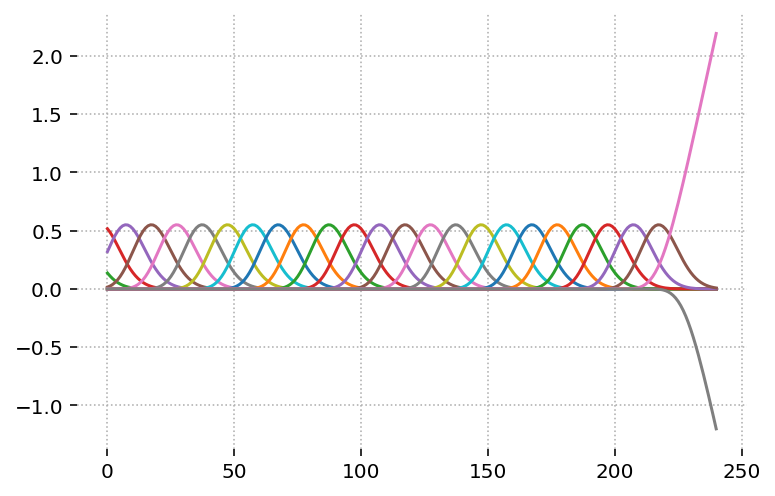

In [347]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

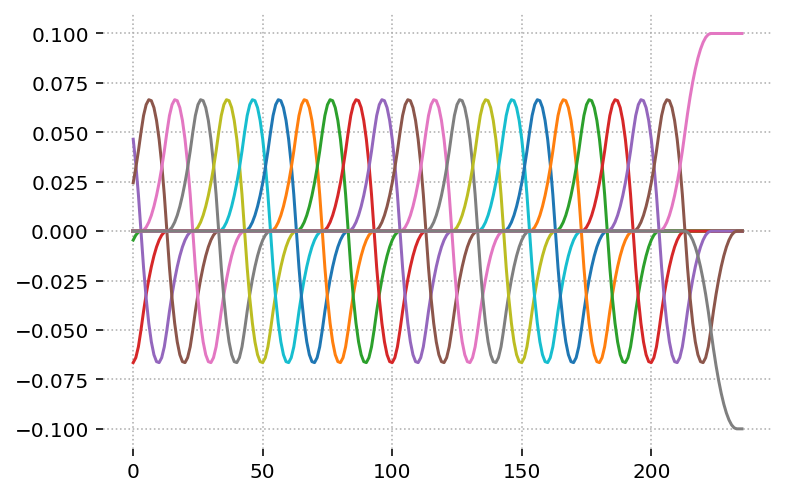

In [348]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [349]:
B0.shape

(2, 241, 28)

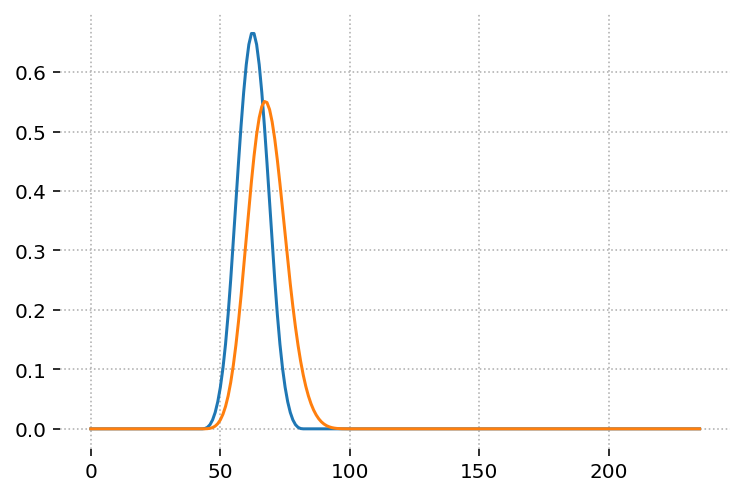

In [350]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


In [351]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.667
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [352]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [353]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [354]:
from numpyro.infer import Trace_ELBO

In [355]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [356]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [357]:
model = MultiLineageTimeShift(
    CC,
    GG,    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)]),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.01,
    b0_scale=0.3,
    c_scale=20,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=100., 
    week=True,
    fit_logits=True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.05, 'lrd': 0.1 ** (1/1000), 'num_samples': 100}

)

In [358]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 2,000 | 0 %
SVI step 1,000 / 2,000 | 50 %


Text(0, 0.5, 'ELBO')

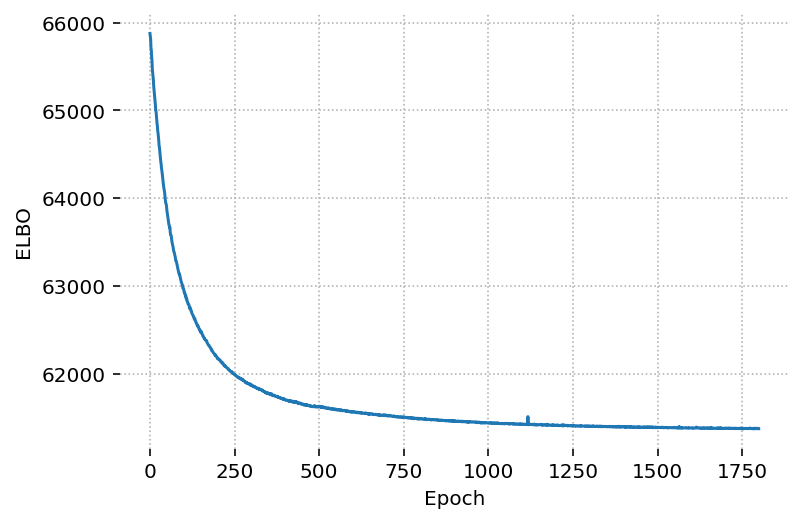

In [359]:
plt.plot(model.loss[200:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

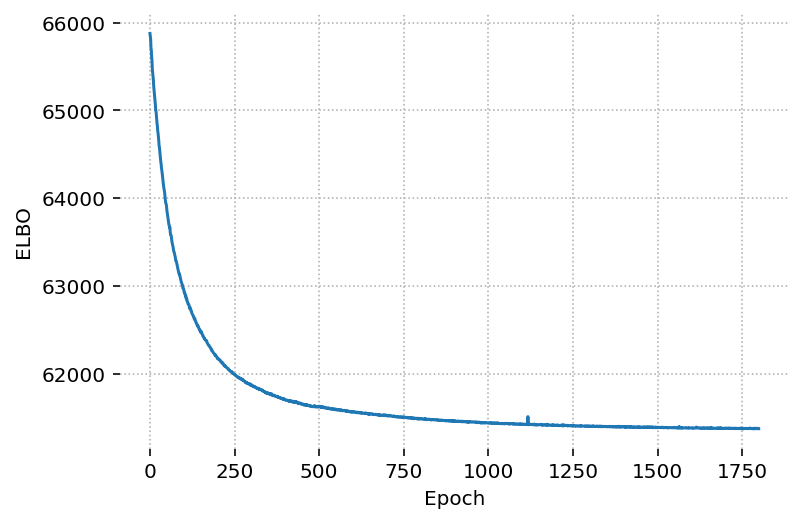

In [360]:
plt.plot(model.loss[200:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((None, model.loss[2000]))

In [361]:
merged_lineages

['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.4',
 'B.1.1.529.5',
 'Other',
 'B.1.617.2']

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/Users/mg14/anaconda3/envs/npy/lib/

<Figure size 432x288 with 0 Axes>

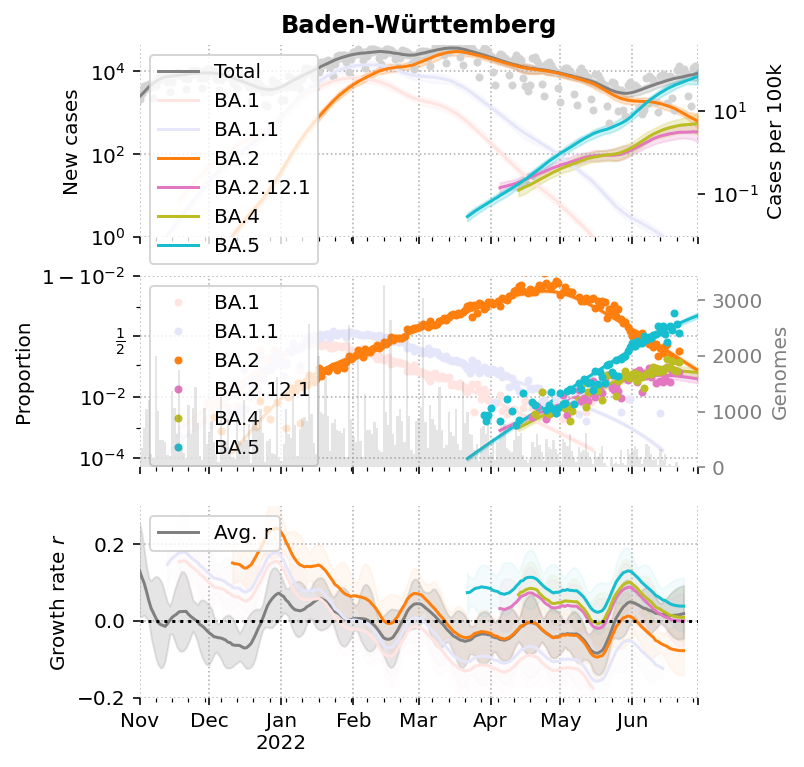

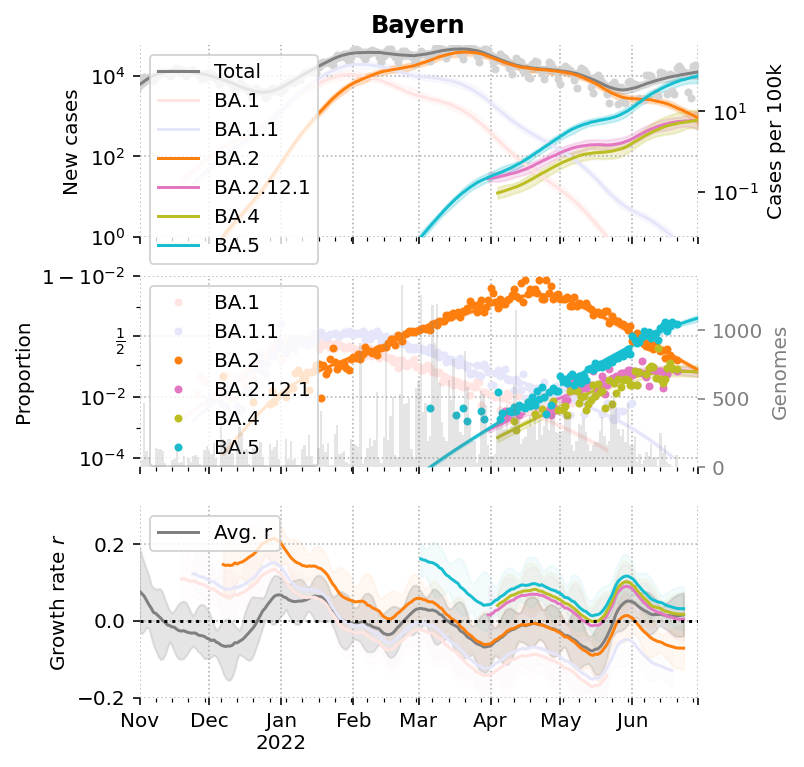

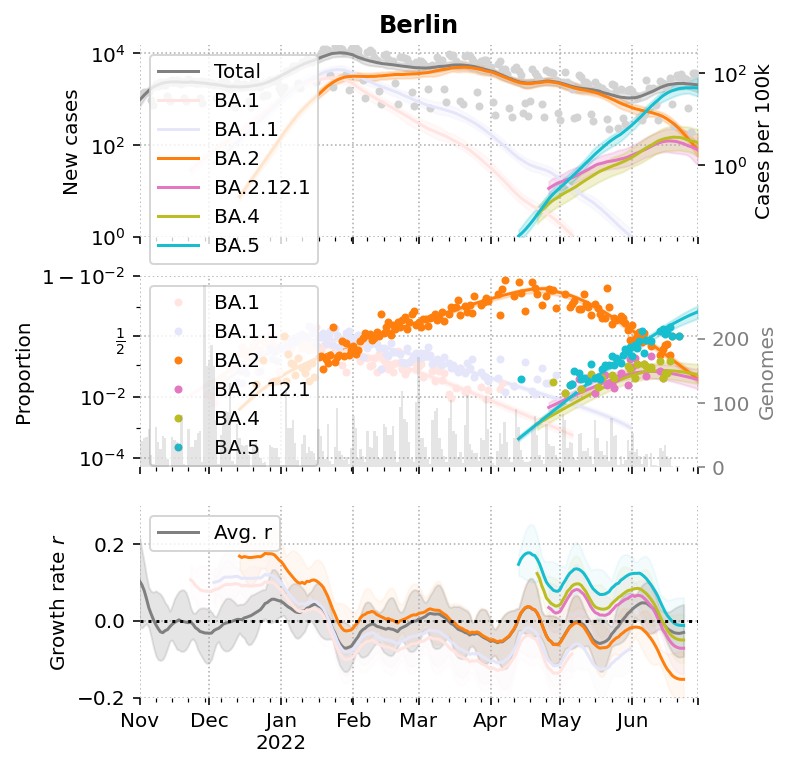

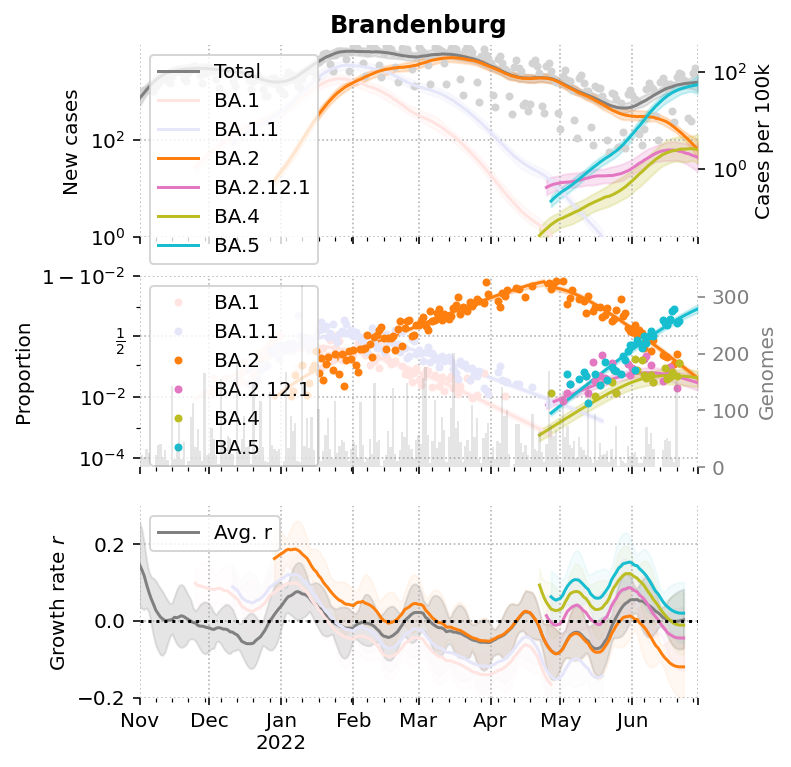

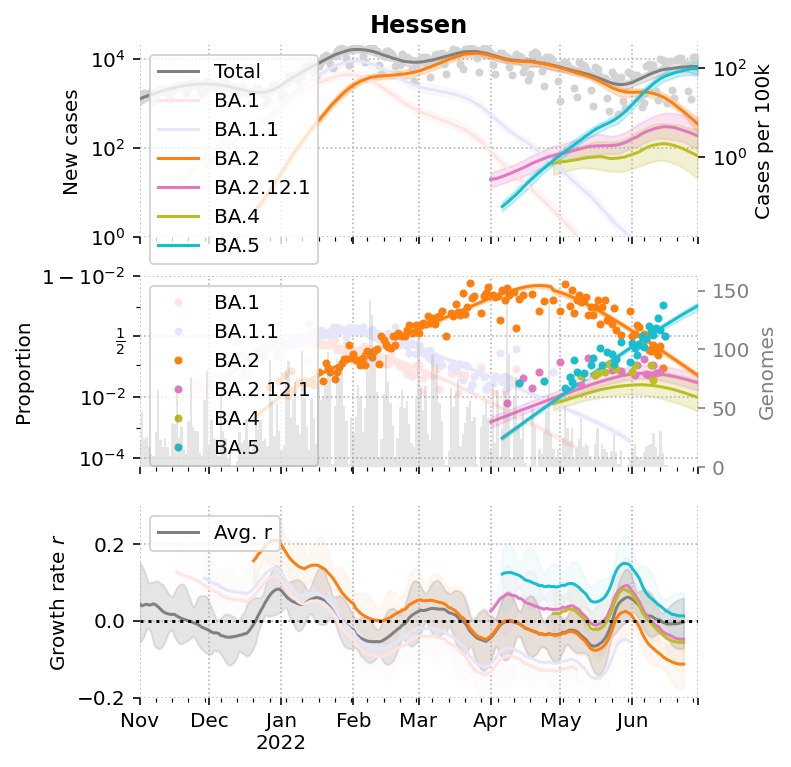

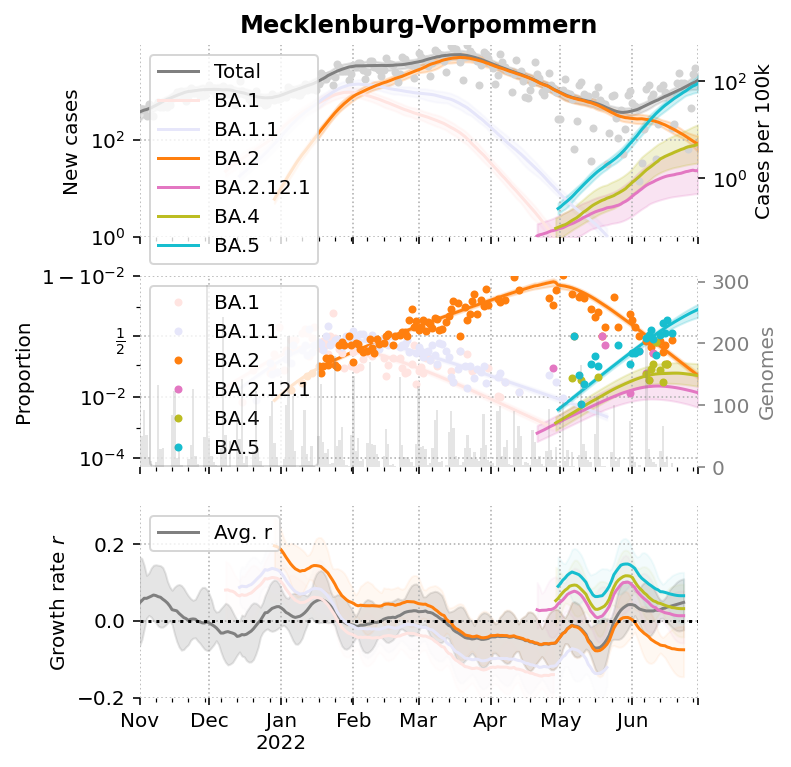

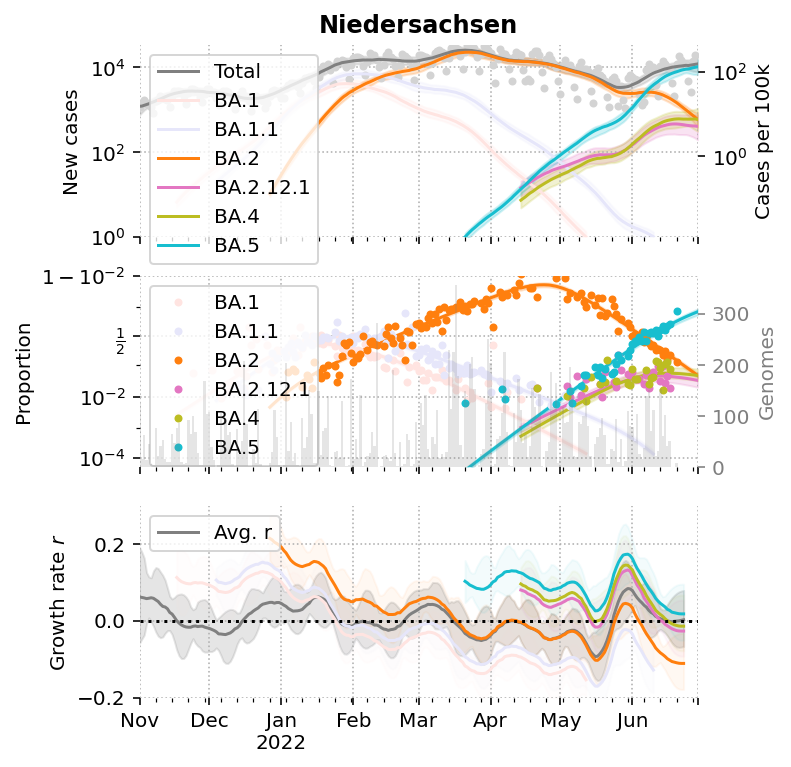

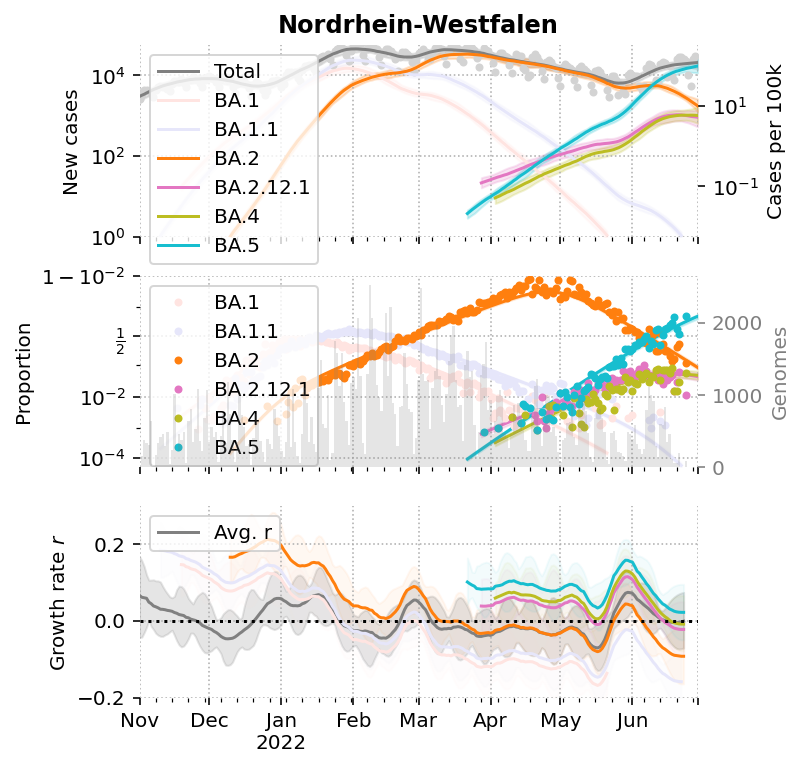

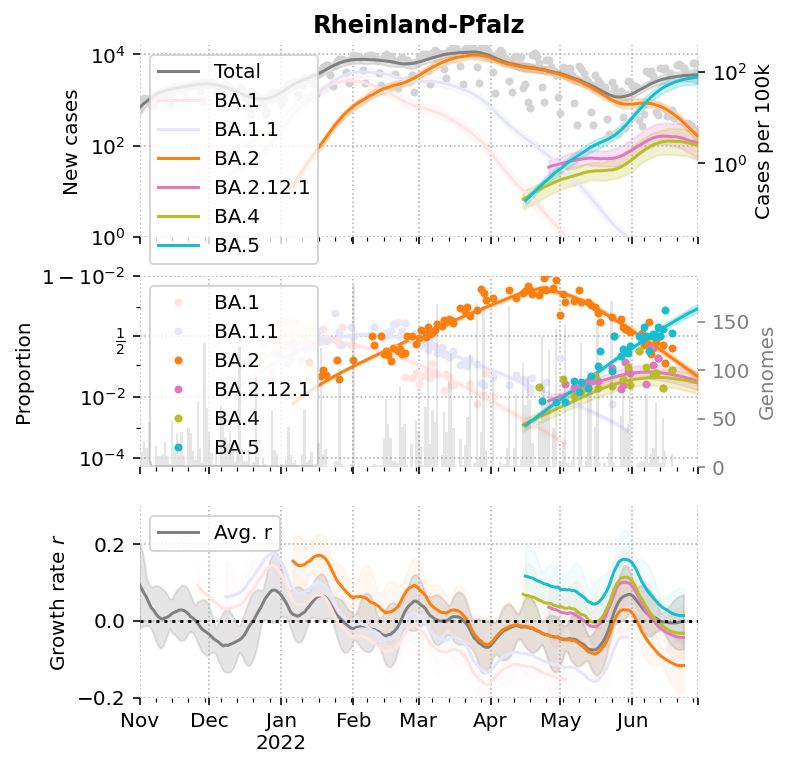

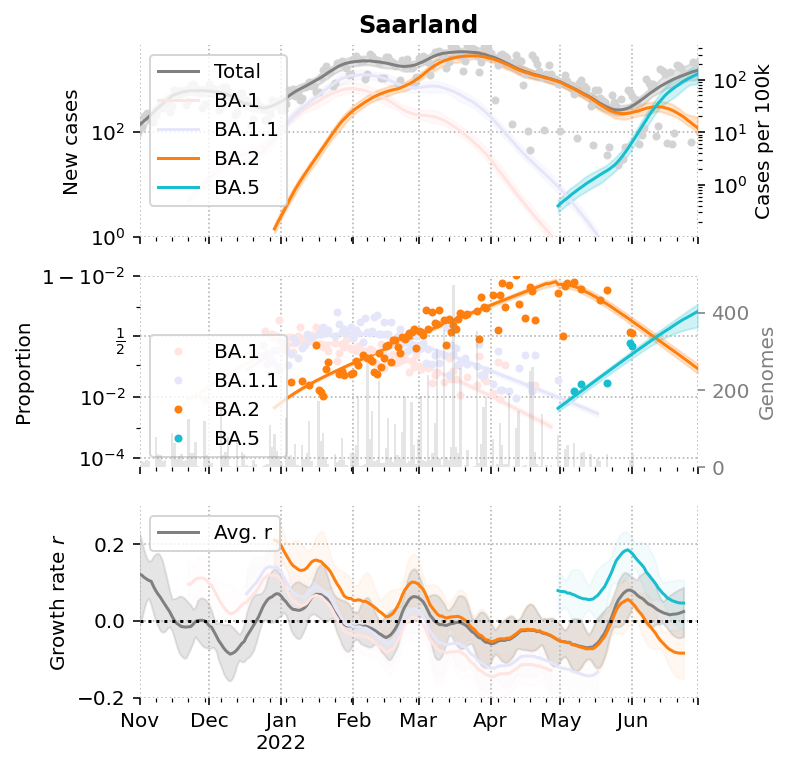

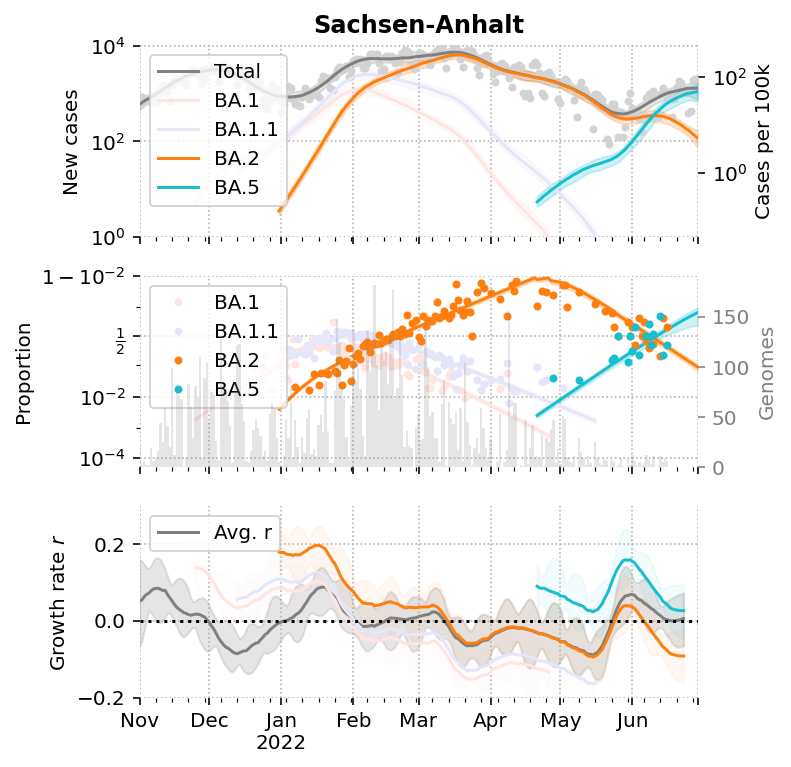

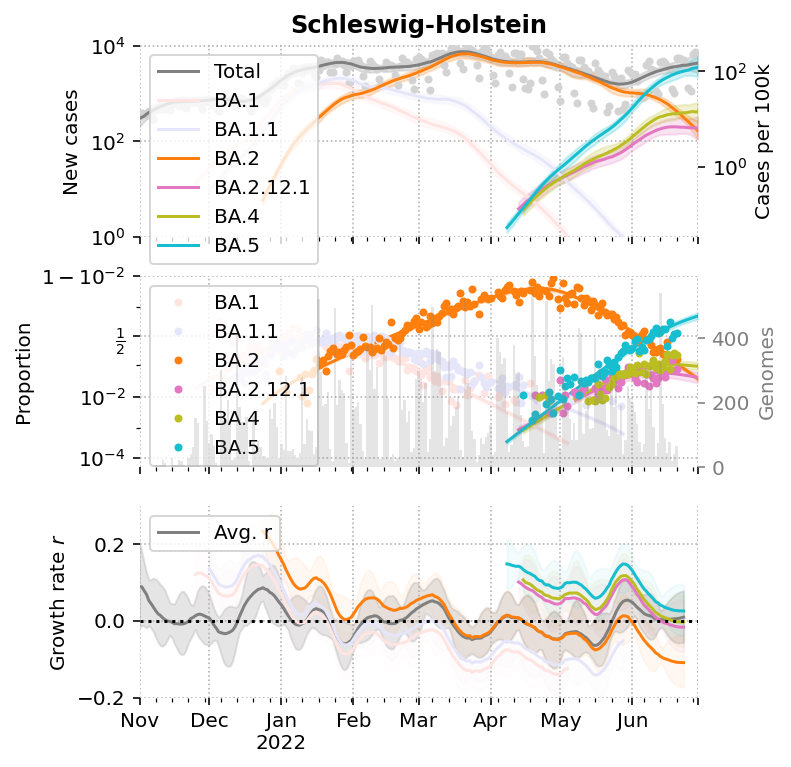

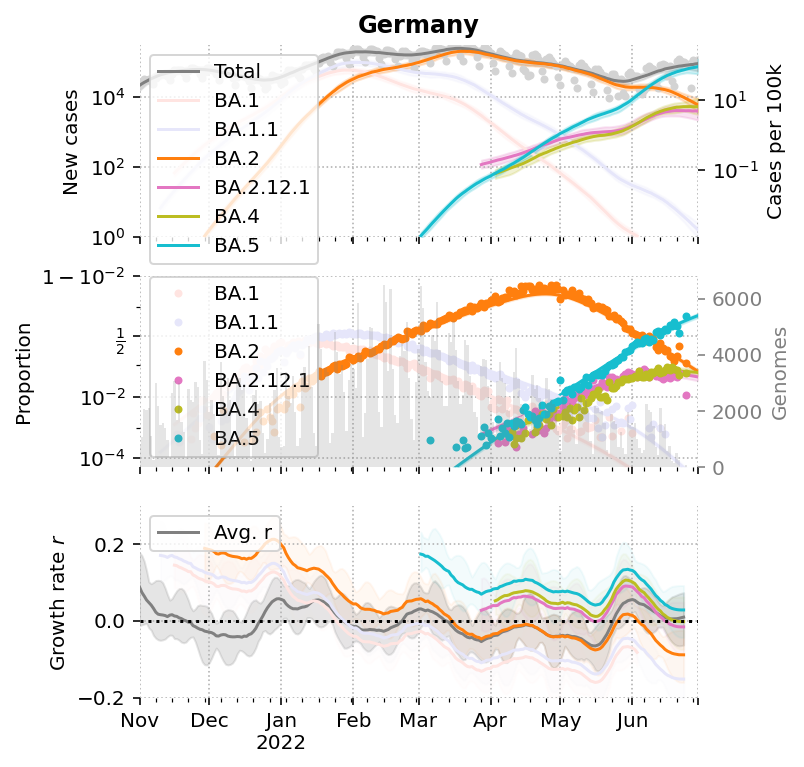

In [362]:
#from genomicsurveillance.plots.england import plot_lad, 
from genomicsurveillance.plots.england import plot_median_and_ci
for i,r in enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 10)[0]
    w = list(set(w) - set([0,GG.shape[2]-2,GG.shape[2]-1]))
    plt.set_cmap("tab20")
    col = ['C7','mistyrose',"lavender","C1", "C6","C8" ,"C9", "C7","aliceblue"]
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = np.array([alias(x) for x in merged_lineages])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((0, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((5e-5,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")

In [382]:
np.quantile(model.get_probabilities()[:,1,-1:,merged_lineages.index("B.1.1.529.5")], (0.025,0.5,0.975))

array([0.75550474, 0.79666448, 0.83027671])

In [364]:
f = pd.DataFrame(GG.sum(1), index=cases_land.index.to_list() + ["Germany"], columns=[alias(x) for x in merged_lineages])

In [365]:
f

B.1.1.529     BA.1    BA.1.1      BA.2  BA.2.12.1  \
Baden-Württemberg           147.0  14418.0   28898.0   51383.0      296.0   
Bayern                       66.0   3957.0    9001.0   32584.0      394.0   
Berlin                       13.0    710.0    1074.0    4229.0       48.0   
Brandenburg                   6.0    928.0    1631.0    5217.0       68.0   
Bremen                       14.0    328.0     891.0    2606.0        1.0   
Hamburg                      98.0   4211.0    4391.0   10530.0       57.0   
Hessen                        7.0   1083.0    1992.0    3479.0       32.0   
Mecklenburg-Vorpommern       14.0    756.0    1000.0    3224.0       20.0   
Niedersachsen                 6.0    972.0    1652.0    8062.0       91.0   
Nordrhein-Westfalen         395.0  18471.0   34718.0   74072.0      801.0   
Rheinland-Pfalz               8.0    453.0     880.0    3983.0       70.0   
Saarland                     46.0   1113.0    2203.0    4834.0        4.0   
Sachsen                     210.0   6270.0   11558.0   21913.0      114.0   
Sachsen-Anhalt                5.0    837.0    1757.0    3213.0        6.0   
Schleswig-Holstein           19.0   3568.0    5294.0   20586.0      279.0   
Thüringen                    23.0    480.0    1244.0    1847.0        6.0   
Germany                    1077.0  58555.0  108184.0  251762.0     2287.0   

                          BA.4     BA.5   Other  B.1.617.2  
Baden-Württemberg        334.0   2234.0   142.0    41430.0  
Bayern                   244.0   2005.0   101.0     6256.0  
Berlin                    40.0    219.0    28.0     2898.0  
Brandenburg               38.0    458.0    24.0     2852.0  
Bremen                     7.0      7.0    12.0      837.0  
Hamburg                   42.0    320.0    98.0     3787.0  
Hessen                    15.0    157.0     6.0     1645.0  
Mecklenburg-Vorpommern    35.0    256.0    19.0     2865.0  
Niedersachsen             95.0    797.0    27.0     3022.0  
Nordrhein-Westfalen      588.0   5134.0   453.0    26487.0  
Rheinland-Pfalz           41.0    302.0    13.0     1517.0  
Saarland                   3.0     21.0    17.0     1779.0  
Sachsen                   72.0    453.0    89.0    15348.0  
Sachsen-Anhalt             4.0     56.0    24.0     2999.0  
Schleswig-Holstein       395.0   1876.0   166.0     3914.0  
Thüringen                 10.0     44.0     7.0     1718.0  
Germany                 1963.0  14339.0  1226.0   119354.0

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, 'Baden-Württemberg'),
  Text(1, 0, 'Bayern'),
  Text(2, 0, 'Berlin'),
  Text(3, 0, 'Brandenburg'),
  Text(4, 0, 'Bremen'),
  Text(5, 0, 'Hamburg'),
  Text(6, 0, 'Hessen'),
  Text(7, 0, 'Mecklenburg-Vorpommern'),
  Text(8, 0, 'Niedersachsen'),
  Text(9, 0, 'Nordrhein-Westfalen'),
  Text(10, 0, 'Rheinland-Pfalz'),
  Text(11, 0, 'Saarland'),
  Text(12, 0, 'Sachsen'),
  Text(13, 0, 'Sachsen-Anhalt'),
  Text(14, 0, 'Schleswig-Holstein'),
  Text(15, 0, 'Thüringen')])

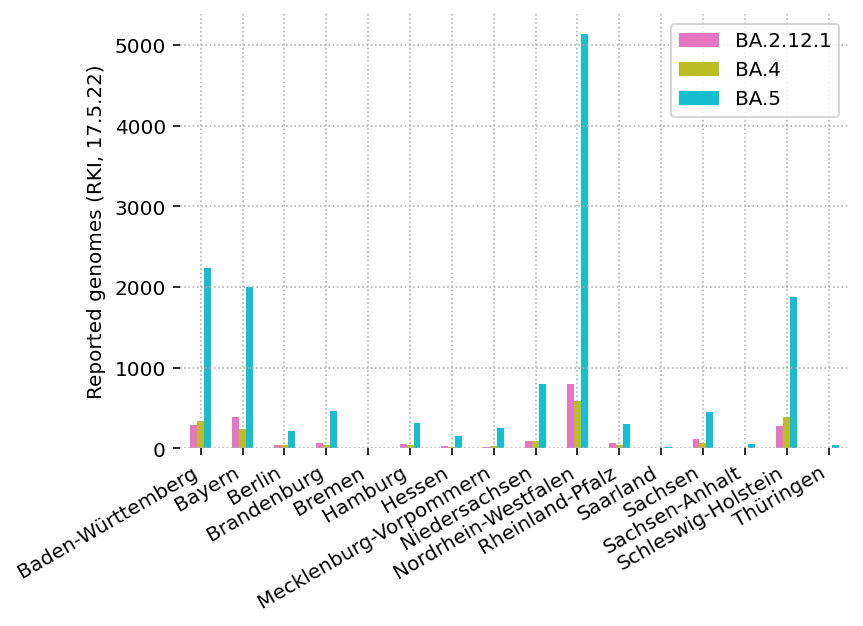

In [366]:
f.iloc[:-1,:].loc[:,["BA.2.12.1","BA.4","BA.5"]].plot.bar(color=["C6","C8" ,"C9"])
plt.ylabel("Reported genomes (RKI, 17.5.22)")
plt.xticks(rotation=30, ha='right')

In [367]:
model.posterior['b1'].mean(0)[-1,0,:]

array([0.17451759, 0.1322769 , 0.15427381, 0.21704197, 0.29096273,
       0.3045893 , 0.3342025 , 0.20756622, 0.        ], dtype=float32)

In [368]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.10830541, 0.11816773, 0.13251851, 0.151784  , 0.26873282,
       0.2618027 , 0.24449311, 0.13187648, 0.        ])

In [369]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

B.1.1.529           0.174518
B.1.1.529.1         0.132277
B.1.1.529.1.1       0.154274
B.1.1.529.2         0.217042
B.1.1.529.2.12.1    0.290963
B.1.1.529.4         0.304589
B.1.1.529.5         0.334203
Other               0.207566
B.1.617.2           0.000000
dtype: float64

In [370]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

1.0000000000000002

In [371]:
model.posterior.keys()

dict_keys(['b1', 'b_scale_lin', 'bc0', 'beta1', 'c1', 't', 'b0'])

In [372]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [373]:
λ.shape

(17, 241, 9)

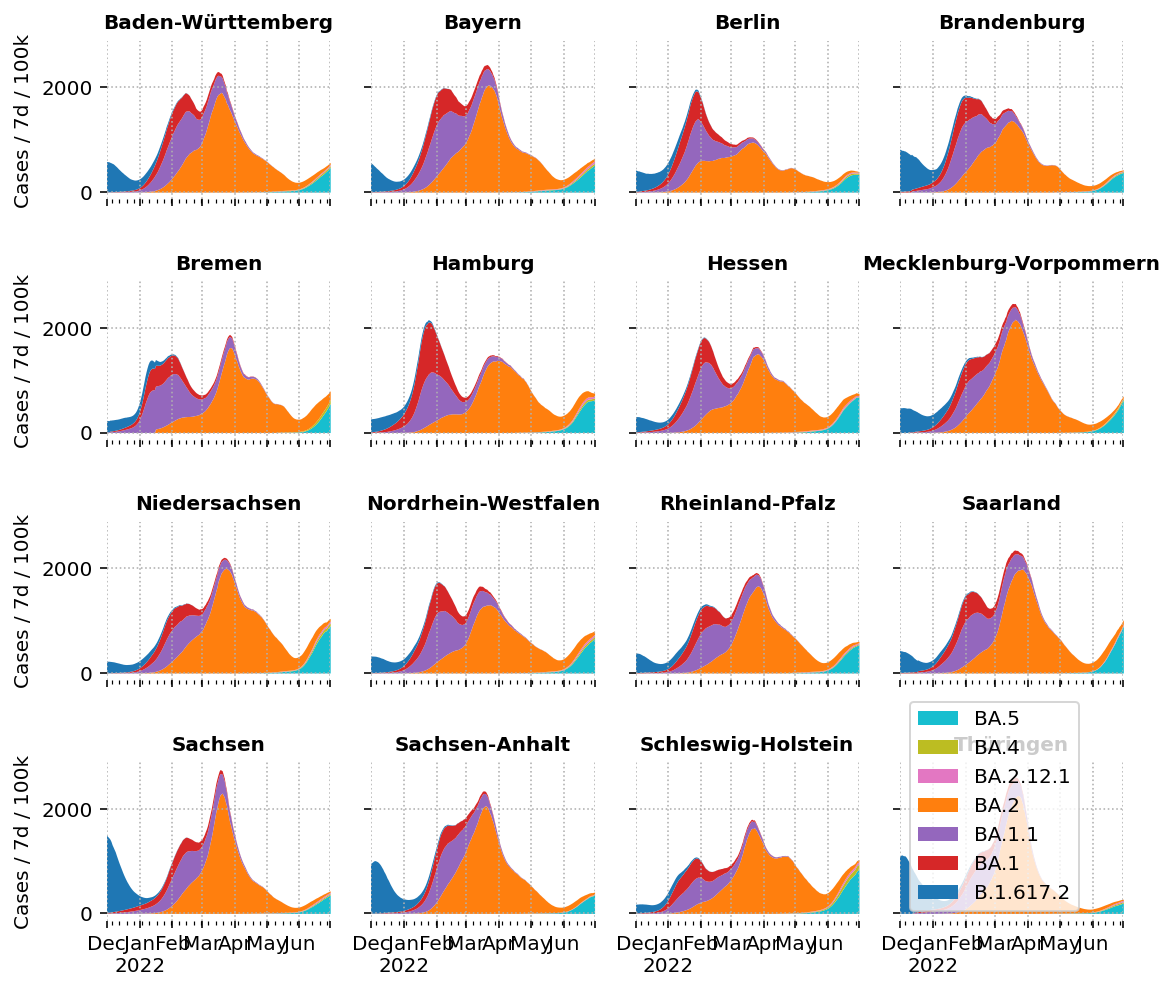

In [374]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
col = ['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"]
labels =[alias(x) for x in merged_lineages]
col = dict(zip(labels, col))
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=labels, index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [375]:
λ[-1,-1] / λ[-1,-1].sum()

array([5.06251700e-06, 4.12396161e-07, 1.88275256e-05, 6.83179483e-02,
       4.52121485e-02, 6.03690583e-02, 8.25827042e-01, 2.49500779e-04,
       3.90181349e-17])

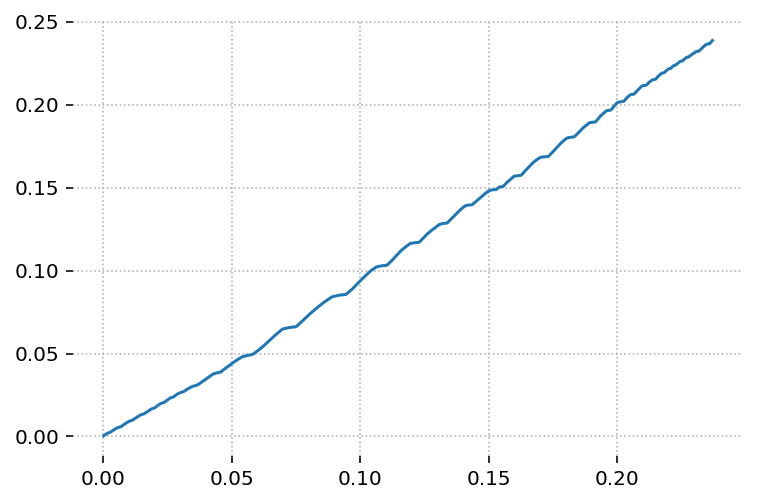

In [376]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

In [377]:
from genomicsurveillance.misc import get_transmissibility

In [378]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=[alias(x) for x in merged_lineages], index=cases_land.index.to_list() + ["Germany"])

In [379]:
r

B.1.1.529  BA.1    BA.1.1      BA.2  BA.2.12.1  \
Baden-Württemberg        0.041938   0.0  0.023002  0.086039   0.161939   
Bayern                   0.033499   0.0  0.019075  0.081084   0.157001   
Berlin                   0.037943   0.0  0.019314  0.074486   0.157724   
Brandenburg              0.037263   0.0  0.021928  0.088002   0.161664   
Bremen                   0.043231   0.0  0.013686  0.078161   0.166404   
Hamburg                  0.059673   0.0  0.026898  0.100397   0.179502   
Hessen                   0.038237   0.0  0.020046  0.092969   0.158768   
Mecklenburg-Vorpommern  -0.014646   0.0  0.022662  0.082670   0.171013   
Niedersachsen            0.009790   0.0  0.023687  0.091318   0.176790   
Nordrhein-Westfalen      0.040397   0.0  0.021196  0.087724   0.158631   
Rheinland-Pfalz          0.004899   0.0  0.031662  0.102942   0.173141   
Saarland                 0.058725   0.0  0.021669  0.091473   0.178530   
Sachsen                  0.046368   0.0  0.024283  0.087953   0.166185   
Sachsen-Anhalt           0.005570   0.0  0.023315  0.093571   0.168209   
Schleswig-Holstein       0.034470   0.0  0.023769  0.090047   0.182621   
Thüringen                0.041427   0.0  0.017764  0.090797   0.186565   
Germany                  0.042241   0.0  0.021997  0.084765   0.158686   

                            BA.4      BA.5     Other  B.1.617.2  
Baden-Württemberg       0.173735  0.202868  0.079102  -0.131451  
Bayern                  0.167906  0.184118  0.054690  -0.135885  
Berlin                  0.175524  0.215107  0.099306  -0.111551  
Brandenburg             0.197653  0.228753  0.103693  -0.105459  
Bremen                  0.159910  0.216000  0.056582  -0.095869  
Hamburg                 0.190001  0.220153  0.096041  -0.113735  
Hessen                  0.148956  0.218299 -0.056780  -0.115456  
Mecklenburg-Vorpommern  0.189814  0.222301  0.087459  -0.111496  
Niedersachsen           0.190834  0.220202  0.079110  -0.113955  
Nordrhein-Westfalen     0.172988  0.202132  0.063591  -0.132280  
Rheinland-Pfalz         0.185176  0.233336  0.085582  -0.100270  
Saarland                0.186603  0.220955  0.017276  -0.111525  
Sachsen                 0.177170  0.206472  0.069651  -0.127782  
Sachsen-Anhalt          0.186711  0.212544 -0.026485  -0.121238  
Schleswig-Holstein      0.195829  0.223807  0.101250  -0.109764  
Thüringen               0.186491  0.201130  0.050662  -0.112082  
Germany                 0.172312  0.201926  0.075289  -0.132277

(array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(1, 0, 'B.1.1.529'),
  Text(2, 0, 'BA.1'),
  Text(3, 0, 'BA.1.1'),
  Text(4, 0, 'BA.2'),
  Text(5, 0, 'BA.2.12.1'),
  Text(6, 0, 'BA.4'),
  Text(7, 0, 'BA.5'),
  Text(8, 0, 'Other'),
  Text(9, 0, 'B.1.617.2')])

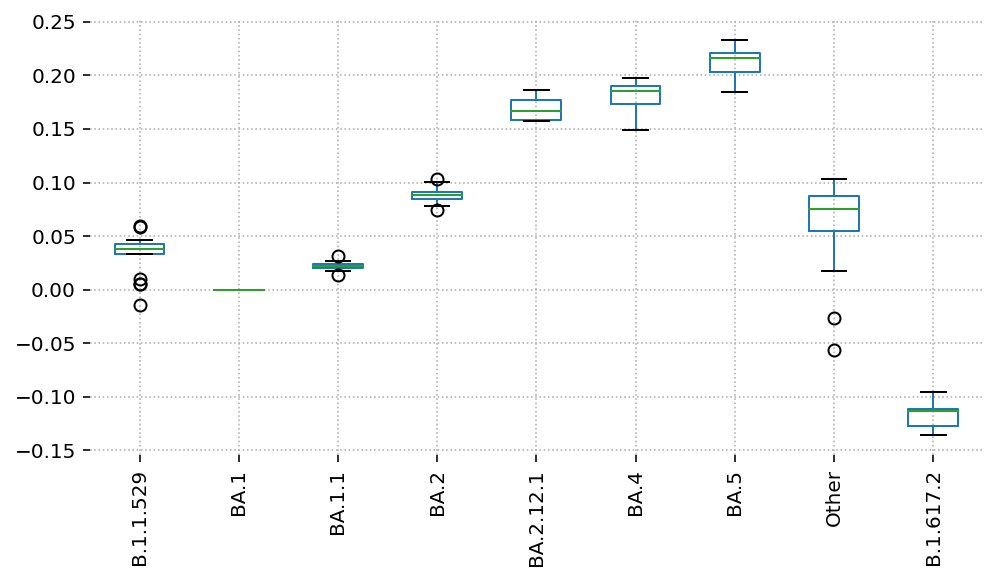

In [380]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


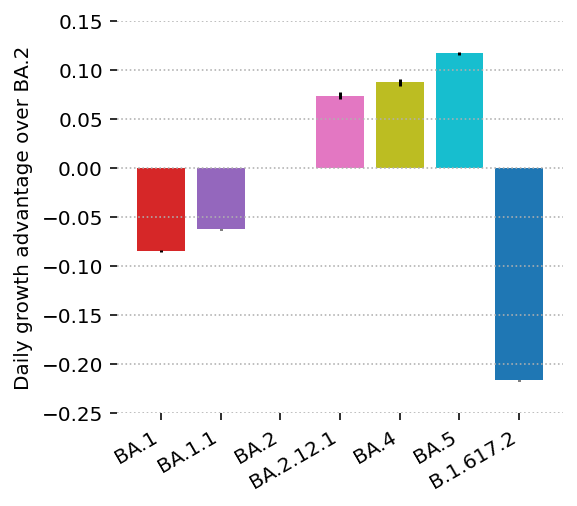

In [381]:
s = pd.DataFrame((b - b[...,[3]]).mean((2))[:,-1], columns=[alias(x) for x in merged_lineages]).iloc[:,[1,2,3,4,5,6,8]]
#s.boxplot()
plt.figure(figsize=(4,4))
plt.bar(s.columns, s.mean(), yerr=2*s.std(), color=['C3',"C4","C1", "C6" ,"C8","C9", "C0"])
plt.ylim((-0.25,0.15))
#plt.draw()
#lt.xticks(rotation=45)
plt.gcf().autofmt_xdate()
plt.ylabel("Daily growth advantage over BA.2")
plt.grid(False)
plt.grid(axis="y")

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
B.1.1.529     974                   0.093908  0.072938   
BA.1       107462                   0.027026  0.007769   
BA.1.1     195312                   0.022135  0.006013   
BA.2       303958                   0.056339  0.010441   
BA.2.12.1      12                  -0.040980  0.050290   
BA.4            8                  -0.033160  0.051499   
BA.5           90                   0.126382  0.024396   
Other        3204                   0.123818  0.032719   
B.1.617.2  238596                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
B.1.1.529                       -0.037938  0.072938  
BA.1                             0.000000  0.006172  
BA.1.1                           0.035643  0.006002  
BA.2                             0.093549  0.009352  
BA.2.12.1                        0.031738  0.050286  
BA.4                            -0.093600  0.051623  
BA.5                             0.080544  0.023910  
Other                            0.014091  0.032719  
B.1.617.2                       -0.152073  0.000000

/Users/mg14/Git/desh-data/genomicsurveillance/misc/misc.py:917: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


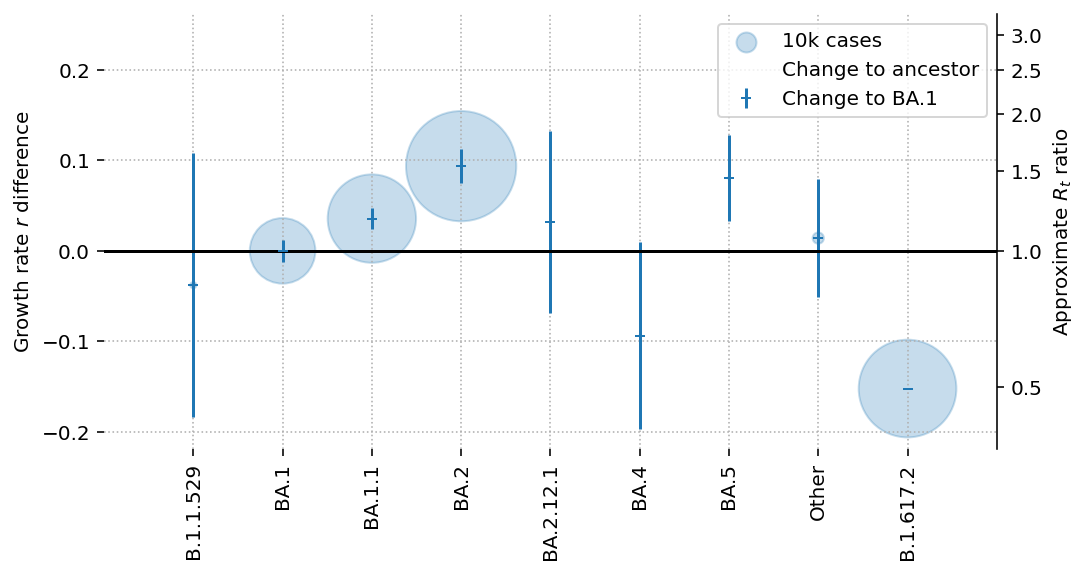

In [148]:
plt.figure(figsize=(8,4))
plot_growth_rates(model, [alias(x) for x in merged_lineages], color=["C0","None"], baseline="BA.1")

In [360]:
import geopandas as gpd

In [381]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [382]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [383]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([2.15288522e-04, 4.90127999e-04, 7.29437608e-03, 9.88248995e-01,
       6.20893242e-04, 1.97671796e-17, 1.93590697e-03, 1.19441189e-03,
       9.26731679e-11])

In [384]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [405]:
vmax

0.0010552848501374573

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


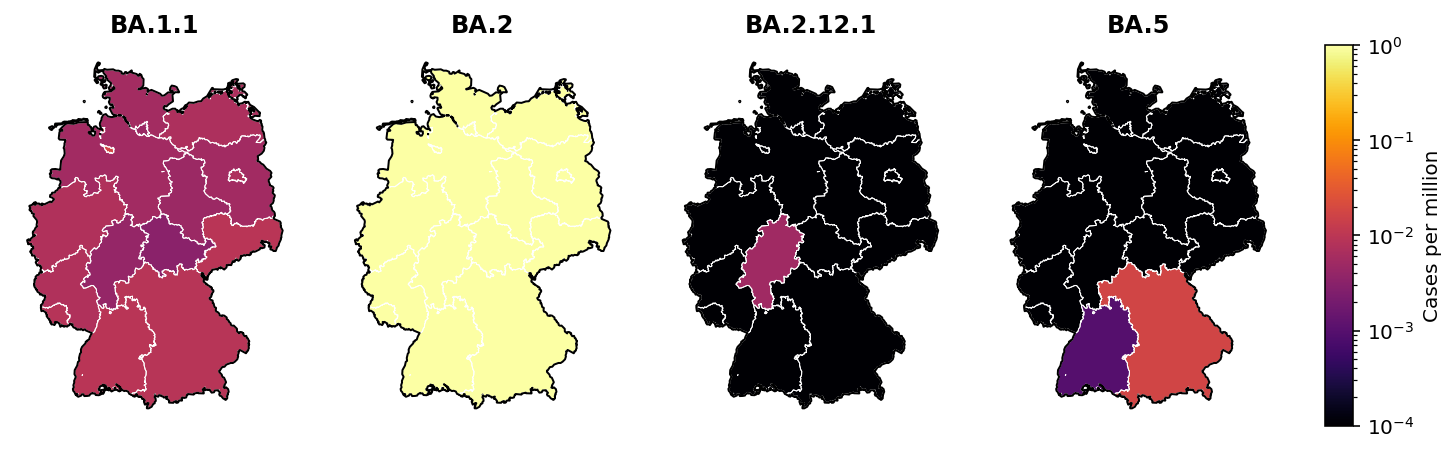

In [436]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = 1#1-1e-2 #λ[:-1,-1,:].max()
vmin = 1e-4
p = model.get_probabilities()
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:]/λ[:-1,-1,:].sum(1, keepdims=True) + 1e-4, columns=[alias(x) for x in merged_lineages], index=bl.index), 
                     left_index=True, right_index=True)
for i, g in enumerate(["BA.1.1","BA.2","BA.2.12.1","BA.5"]):
    b0.plot(g, ax=axs[i], cmap="inferno",#["Purples","Oranges","GnBu","RdPu"][i], 
            norm=LogNorm(vmin=vmin, vmax=vmax), 
            cax=axs[4],
            legend_kwds={'label': "Cases per million", 'pad':0.3}, 
            legend=i==0, 
            missing_kwds= dict(color = "lightgrey"))
#b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
#b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
#b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
    axs[i].set_title(g, weight='bold')
for ax in axs[:-1]:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [386]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

B.1.1.529      BA.1     BA.1.1          BA.2  \
bundesland                                                                
Baden-Württemberg       1.883543e+00  3.079631  52.642528   5634.712014   
Bayern                  9.239523e-01  7.011032  82.398169   8932.680753   
Berlin                  7.129156e-02  1.230208  15.494119   2098.838582   
Brandenburg             1.045944e-11  0.393579   7.313904   1355.588718   
Bremen                  1.695011e-12  0.718811   8.141248    440.112645   
Hamburg                 5.999631e-01  0.583647   9.072471   1954.758359   
Hessen                  5.292444e-14  1.638437  26.702307   6618.295355   
Mecklenburg-Vorpommern  8.967187e-02  0.376390   4.663220    664.720074   
Niedersachsen           3.970144e-07  1.786235  33.371726   6030.588211   
Nordrhein-Westfalen     4.840199e+00  7.301521  90.099141  11858.489882   
Rheinland-Pfalz         2.424459e-12  0.683199  27.570891   3611.656835   
Saarland                3.474684e-01  0.559327   9.063536   1038.390795   
Sachsen                 8.853864e-01  0.698149  15.200453   1586.023408   
Sachsen-Anhalt          8.796976e-03  0.275390   5.612932   1184.911661   
Schleswig-Holstein      1.297336e-12  1.193746  16.357342   2855.009578   
Thüringen               6.466811e-09  0.168431   2.454498    779.794371   

                           BA.2.12.1          BA.4          BA.5     Other  \
bundesland                                                                   
Baden-Württemberg       3.105715e-11  7.678868e-14  5.064922e+00  4.380167   
Bayern                  2.519557e-09  1.716826e-12  1.611692e+02  1.700485   
Berlin                  0.000000e+00  0.000000e+00  5.528965e-09  0.818255   
Brandenburg             0.000000e+00  0.000000e+00  0.000000e+00  1.760799   
Bremen                  0.000000e+00  0.000000e+00  0.000000e+00  1.139284   
Hamburg                 0.000000e+00  0.000000e+00  4.329695e-09  5.784102   
Hessen                  3.540015e+01  0.000000e+00  1.415664e-09  0.208422   
Mecklenburg-Vorpommern  0.000000e+00  0.000000e+00  0.000000e+00  0.227734   
Niedersachsen           0.000000e+00  0.000000e+00  1.259503e-07  9.591274   
Nordrhein-Westfalen     8.869462e-09  1.560993e-12  5.445674e-09  7.262824   
Rheinland-Pfalz         0.000000e+00  0.000000e+00  0.000000e+00  0.032172   
Saarland                0.000000e+00  0.000000e+00  0.000000e+00  1.823491   
Sachsen                 0.000000e+00  0.000000e+00  7.374251e-10  3.693537   
Sachsen-Anhalt          0.000000e+00  0.000000e+00  0.000000e+00  0.002043   
Schleswig-Holstein      1.139780e-09  0.000000e+00  5.317432e-08  6.993398   
Thüringen               0.000000e+00  0.000000e+00  6.953959e-09  0.239284   

                           B.1.617.2  
bundesland                            
Baden-Württemberg       4.010882e-07  
Bayern                  3.028661e-07  
Berlin                  1.005914e-07  
Brandenburg             3.421493e-07  
Bremen                  1.202942e-08  
Hamburg                 7.259104e-08  
Hessen                  7.024828e-08  
Mecklenburg-Vorpommern  4.142959e-08  
Niedersachsen           7.021541e-07  
Nordrhein-Westfalen     4.510040e-07  
Rheinland-Pfalz         3.389480e-07  
Saarland                2.721392e-08  
Sachsen                 8.016983e-08  
Sachsen-Anhalt          7.507915e-08  
Schleswig-Holstein      8.749001e-07  
Thüringen               8.240026e-08

In [65]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-1.17073431e-01, -8.72409463e-02, -2.49905770e-02,
        -3.33996603e-01, -2.40221833e-01, -2.56206262e-01],
       [-9.53045288e-02, -7.66980709e-02, -1.01037425e-02,
        -4.51850657e-01, -1.81135403e-01, -2.40760578e-01],
       [-8.50041977e-02, -6.02728009e-02, -4.07334947e-03,
        -2.27750612e-01, -2.02436696e-01, -2.27750612e-01],
       [-1.11172666e-01, -8.15255004e-02, -1.39356918e-02,
        -3.03596317e-01, -2.44137866e-01, -2.44137866e-01],
       [-5.44851079e-02, -3.83661998e-02,  3.11813242e-02,
        -1.96419871e-01, -1.40428822e-01, -1.96419871e-01],
       [-1.44524835e-01, -1.17987621e-01, -3.75336103e-02,
        -3.45094824e-01, -2.08678367e-01, -2.68897737e-01],
       [-1.17924524e-01, -9.33053921e-02, -1.65491929e-02,
        -3.16804863e-01, -2.15071610e-01, -2.47860992e-01],
       [-1.08861593e-01, -8.06443087e-02, -2.28301704e-02,
        -2.49512284e-01, -2.49512284e-01, -2.49512284e-01],
       [-1.23489015e-01, -9.37075788e-02, -2.636

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


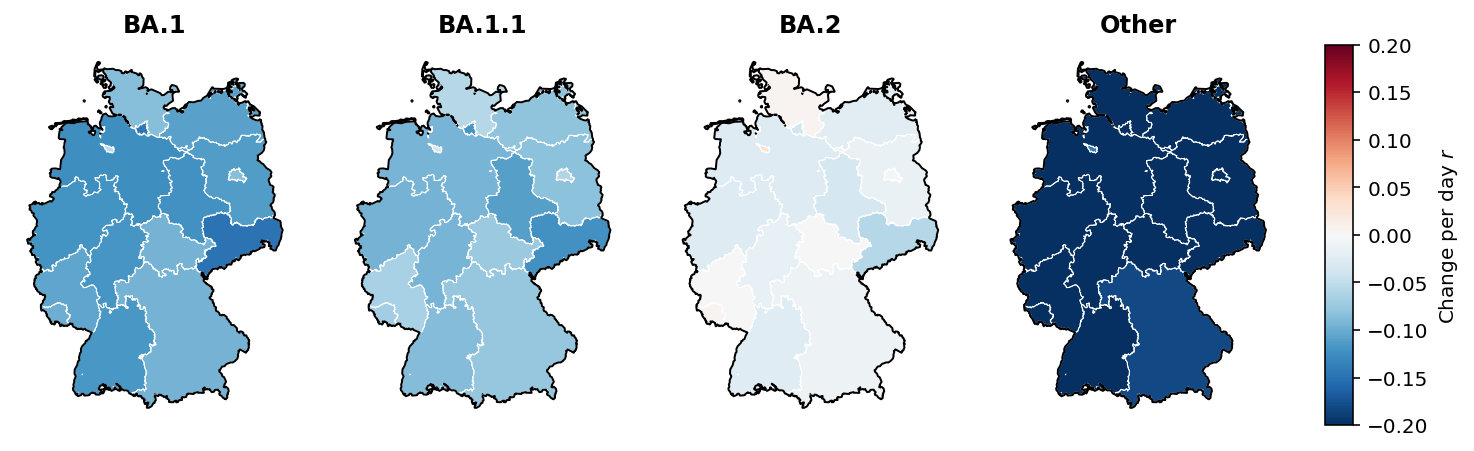

In [66]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [67]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

In [68]:
j

24

0.07069868281110661
0.08626862616509487
0.04385605918808592
0.042607422277869476


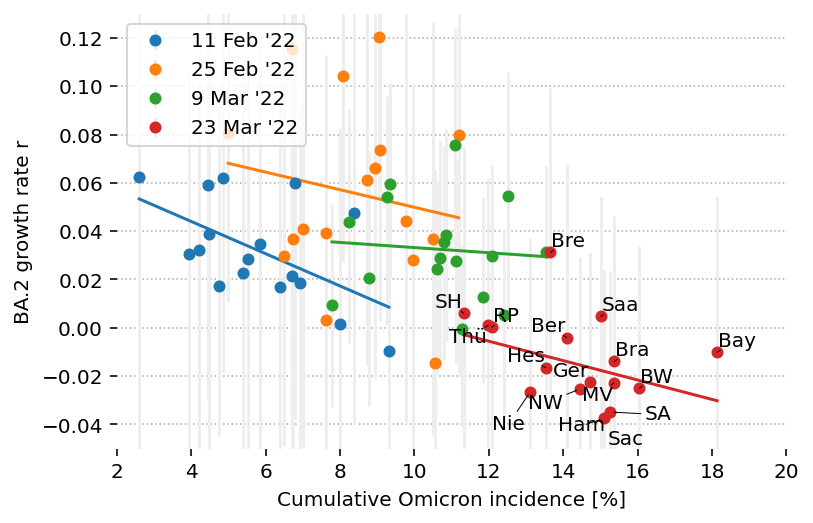

In [80]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
text=[]
for k,l in enumerate(["2022-02-11", "2022-02-25","2022-03-09","2022-03-23"]):
    j = np.where(cases_land.columns == l)[0][0]
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    
    for i in range(x.shape[0]):
        if k==3:#l[i]#in ["BW","NW","RP","Saa"]:
            text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.05,0.13))
    ax.set_xlim((2,20))
    print(lr.intercept_)

adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )
ax.grid(axis='x', which='major')
ax.legend(loc='upper left')


In [70]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.9340922296138215

In [71]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

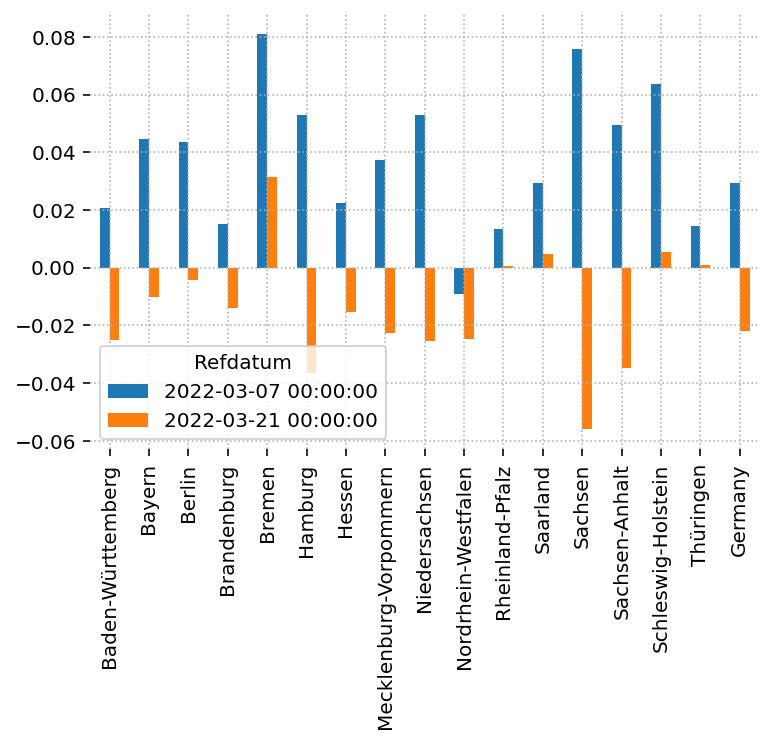

In [72]:
d.plot.bar()

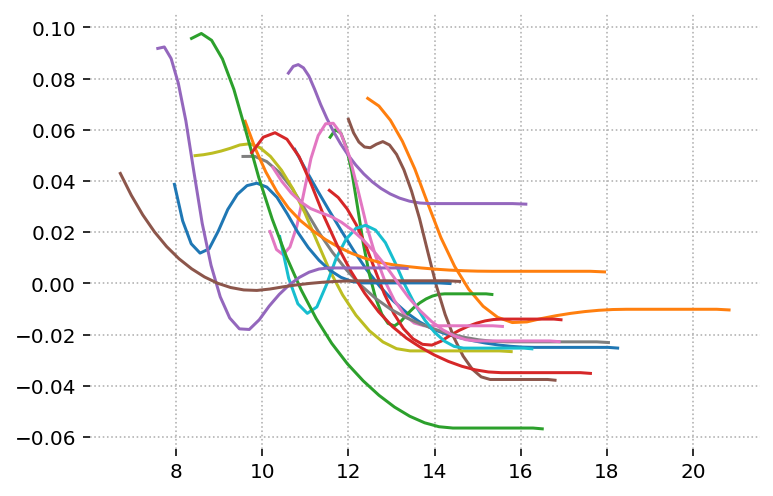

In [73]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

(18962.0, 19077.0)

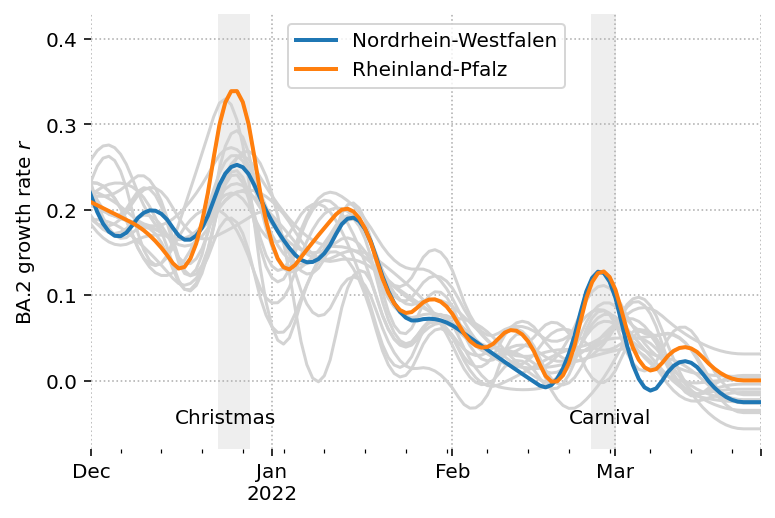

In [74]:
r = np.mean(model.get_growth_rate_lineage(ltla=None),0)[:,:,2]
r = pd.DataFrame(r.T[:-5], index=cases_land.columns[:-4].to_list(), columns=cases_land.index.to_list() + ["Germany"])
r.plot(c = 'lightgrey', alpha=1, legend=False)
r[["Nordrhein-Westfalen","Rheinland-Pfalz"]].plot( alpha=1, lw=2, ax=plt.gca())
#plt.legend("off")
plt.ylabel("BA.2 growth rate $r$")
plt.axvspan("2021-12-23","2021-12-28", color='#EEEEEE', zorder=0)
plt.axvspan("2022-02-25","2022-03-01", color='#EEEEEE', zorder=0)
plt.text("2021-12-24",-0.05,"Christmas", ha='center')
plt.text("2022-02-28",-0.05,"Carnival", ha='center')
plt.xlim(("2021-12-01",None))

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


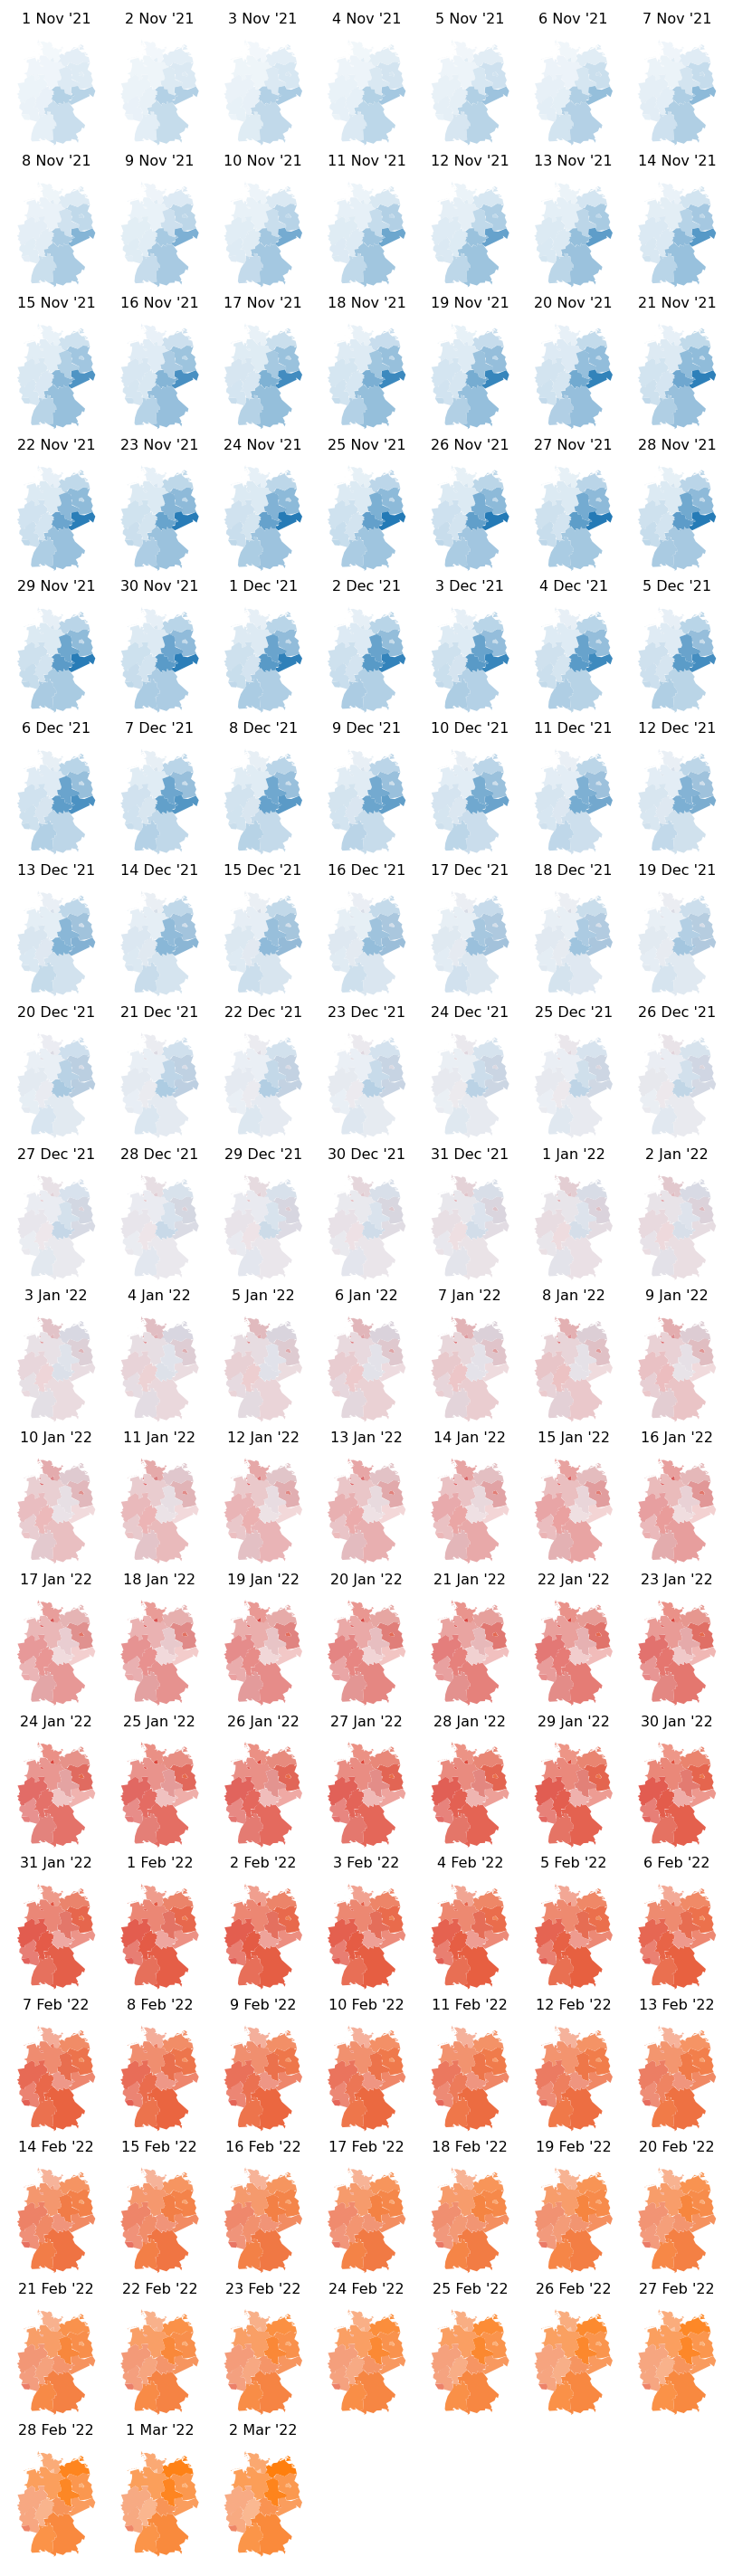

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

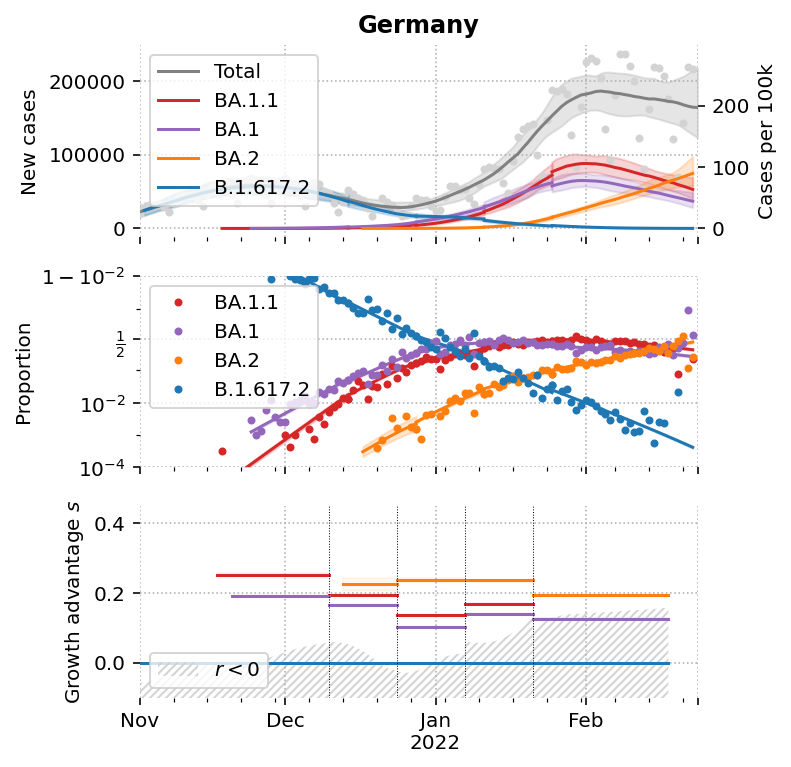

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


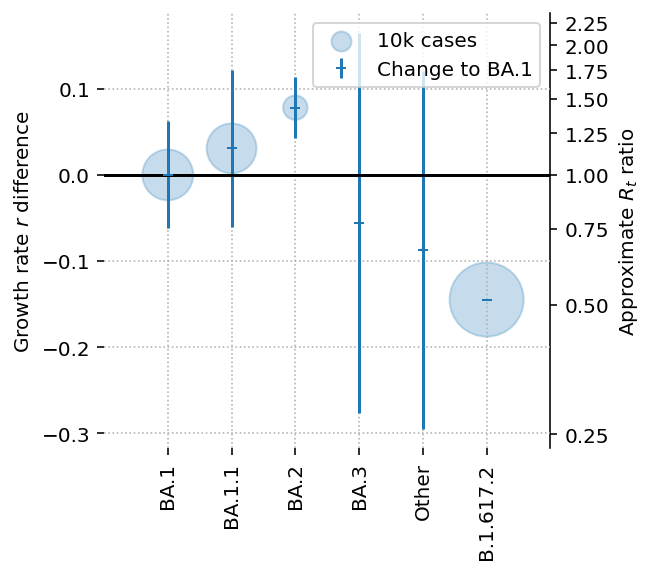

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
